# LendingClub Project

## Introduction

The goal of this project is to apply machine learning techniques to
automated loan decisions for LendingClub.

LendingClub is an American peer-to-peer lending company. It holds the 
distinction of being the first peer-to-peer lender to register its offerings 
as securities with the Securities and Exchange Commission (SEC). Additionally, 
it offers loan trading on a secondary market. LendingClub aims to fully 
automate their lending decisions. Our objective is to construct and deploy 
machine learning models that can assist them in realizing this ambition.

The notebook is structured as follows:

1. **Data Preprocessing:** Prepare the data for EDA and machine learning.
2. **Exploratory Data Analysis (EDA):** Delve into the dataset through 
descriptive statistics and visualizations. 
3. **Predicting Loan Status** 
4. **Predicting Loan Grade:**
5. **Predicting Loan Sub-Grade:**
6. **Predicting Loan Interest Rate:**
7. **Model Deployment:** Deploy the top-performing models to the Google Cloud 
Platform.
8. **Conclusions and Further Improvements:** Reflect on the results, recognize 
limitations, and propose suggestions for future endeavors.


## 1. Data Preprocessing

In [1]:
import os
import time
import json
import joblib
import pickle
import requests
import shap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import lightgbm as lgb
import plotly.express as px

from collections import Counter
from typing import Dict, Any
from scipy.stats import zscore, randint, uniform
from IPython.display import Image

from sklearn.metrics import (accuracy_score, classification_report, precision_score,
                             recall_score, f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve, mean_absolute_error, mean_squared_error,
                             r2_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import (LogisticRegression, LinearRegression, Ridge,
                                  Lasso, ElasticNet)
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              GradientBoostingRegressor)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     StratifiedKFold, KFold)

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from feature_engine.selection import (RecursiveFeatureElimination,
                                      SmartCorrelatedSelection,
                                      DropDuplicateFeatures,
                                      DropConstantFeatures)

sns.set_style("whitegrid")
sns.set_palette("muted")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [15]:
%%time
# Load the accepted loans dataframe
accepted_df_full = pd.read_csv('accepted_2007_to_2018Q4.csv',
                               low_memory=False)
accepted_df_full.shape

CPU times: total: 1min 26s
Wall time: 1min 36s


(2260701, 151)

In [3]:
%%time
# Load the rejected loans dataframe
rejected_df = pd.read_csv('rejected_2007_to_2018Q4.csv',
                          low_memory=False)
rejected_df.shape

CPU times: total: 44.2 s
Wall time: 45.3 s


(27648741, 9)

In [5]:
accepted_df_full.head(10)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN    3600.00      3600.00          3600.00   36 months   
1  68355089        NaN   24700.00     24700.00         24700.00   36 months   
2  68341763        NaN   20000.00     20000.00         20000.00   60 months   
3  66310712        NaN   35000.00     35000.00         35000.00   60 months   
4  68476807        NaN   10400.00     10400.00         10400.00   60 months   
5  68426831        NaN   11950.00     11950.00         11950.00   36 months   
6  68476668        NaN   20000.00     20000.00         20000.00   36 months   
7  67275481        NaN   20000.00     20000.00         20000.00   36 months   
8  68466926        NaN   10000.00     10000.00         10000.00   36 months   
9  68616873        NaN    8000.00      8000.00          8000.00   36 months   

   int_rate  installment grade sub_grade  \
0     13.99       123.03     C        C4   
1     11.99       820.28     C        C1   
2     10.78       432.66     B        B4   
3     14.85       829.90     C        C5   
4     22.45       289.91     F        F1   
5     13.44       405.18     C        C3   
6      9.17       637.58     B        B2   
7      8.49       631.26     B        B1   
8      6.49       306.45     A        A2   
9     11.48       263.74     B        B5   

                                 emp_title emp_length home_ownership  \
0                                  leadman  10+ years       MORTGAGE   
1                                 Engineer  10+ years       MORTGAGE   
2                             truck driver  10+ years       MORTGAGE   
3              Information Systems Officer  10+ years       MORTGAGE   
4                      Contract Specialist    3 years       MORTGAGE   
5                     Veterinary Tecnician    4 years           RENT   
6  Vice President of Recruiting Operations  10+ years       MORTGAGE   
7                              road driver  10+ years       MORTGAGE   
8                          SERVICE MANAGER    6 years           RENT   
9                           Vendor liaison  10+ years       MORTGAGE   

   annual_inc verification_status   issue_d loan_status pymnt_plan  \
0    55000.00        Not Verified  Dec-2015  Fully Paid          n   
1    65000.00        Not Verified  Dec-2015  Fully Paid          n   
2    63000.00        Not Verified  Dec-2015  Fully Paid          n   
3   110000.00     Source Verified  Dec-2015     Current          n   
4   104433.00     Source Verified  Dec-2015  Fully Paid          n   
5    34000.00     Source Verified  Dec-2015  Fully Paid          n   
6   180000.00        Not Verified  Dec-2015  Fully Paid          n   
7    85000.00        Not Verified  Dec-2015  Fully Paid          n   
8    85000.00        Not Verified  Dec-2015  Fully Paid          n   
9    42000.00        Not Verified  Dec-2015  Fully Paid          n   

                                                 url desc             purpose  \
0  https://lendingclub.com/browse/loanDetail.acti...  NaN  debt_consolidation   
1  https://lendingclub.com/browse/loanDetail.acti...  NaN      small_business   
2  https://lendingclub.com/browse/loanDetail.acti...  NaN    home_improvement   
3  https://lendingclub.com/browse/loanDetail.acti...  NaN  debt_consolidation   
4  https://lendingclub.com/browse/loanDetail.acti...  NaN      major_purchase   
5  https://lendingclub.com/browse/loanDetail.acti...  NaN  debt_consolidation   
6  https://lendingclub.com/browse/loanDetail.acti...  NaN  debt_consolidation   
7  https://lendingclub.com/browse/loanDetail.acti...  NaN      major_purchase   
8  https://lendingclub.com/browse/loanDetail.acti...  NaN         credit_card   
9  https://lendingclub.com/browse/loanDetail.acti...  NaN         credit_card   

                     title zip_code addr_state   dti  delinq_2yrs  \
0       Debt consolidation    190xx         PA  5.91         0.00   
1                 Business    577xx         SD 16.06        

In [5]:
rejected_df.head()

Amount Requested Application Date                        Loan Title  \
0           1000.00       2007-05-26  Wedding Covered but No Honeymoon   
1           1000.00       2007-05-26                Consolidating Debt   
2          11000.00       2007-05-27       Want to consolidate my debt   
3           6000.00       2007-05-27                           waksman   
4           1500.00       2007-05-27                            mdrigo   

   Risk_Score Debt-To-Income Ratio Zip Code State Employment Length  \
0      693.00                  10%    481xx    NM           4 years   
1      703.00                  10%    010xx    MA          < 1 year   
2      715.00                  10%    212xx    MD            1 year   
3      698.00               38.64%    017xx    MA          < 1 year   
4      509.00                9.43%    209xx    MD          < 1 year   

   Policy Code  
0         0.00  
1         0.00  
2         0.00  
3         0.00  
4         0.00

In [6]:
# Creating risk_score column, taking average of fico scores
accepted_df_full['risk_score'] = (accepted_df_full['fico_range_low'] +
                                accepted_df_full['fico_range_high']) / 2

In [7]:
accepted_df = accepted_df_full[['loan_amnt', 'issue_d', 'title', 'risk_score',
                                'dti', 'zip_code', 'addr_state', 'emp_length',
                                'policy_code']]

In [ ]:
# Assigning new column names to match each other.
col_names = ['loan_amnt','date_issue','title','risk_score','debt_to_income',
             'zip_code','state','emp_length','policy_code']
accepted_df.columns = col_names
rejected_df.columns = col_names

# Convert the 'date_issue' column to datetime
accepted_df['date_issue'] = pd.to_datetime(accepted_df['date_issue'])
rejected_df['date_issue'] = pd.to_datetime(rejected_df['date_issue'])

In [9]:
accepted_df.head()

loan_amnt date_issue               title  risk_score  debt_to_income  \
0    3600.00 2015-12-01  Debt consolidation      677.00            5.91   
1   24700.00 2015-12-01            Business      717.00           16.06   
2   20000.00 2015-12-01                 NaN      697.00           10.78   
3   35000.00 2015-12-01  Debt consolidation      787.00           17.06   
4   10400.00 2015-12-01      Major purchase      697.00           25.37   

  zip_code state emp_length  policy_code  
0    190xx    PA  10+ years         1.00  
1    577xx    SD  10+ years         1.00  
2    605xx    IL  10+ years         1.00  
3    076xx    NJ  10+ years         1.00  
4    174xx    PA    3 years         1.00

In [10]:
rejected_df.head()

loan_amnt date_issue                             title  risk_score  \
0    1000.00 2007-05-26  Wedding Covered but No Honeymoon      693.00   
1    1000.00 2007-05-26                Consolidating Debt      703.00   
2   11000.00 2007-05-27       Want to consolidate my debt      715.00   
3    6000.00 2007-05-27                           waksman      698.00   
4    1500.00 2007-05-27                            mdrigo      509.00   

  debt_to_income zip_code state emp_length  policy_code  
0            10%    481xx    NM    4 years         0.00  
1            10%    010xx    MA   < 1 year         0.00  
2            10%    212xx    MD     1 year         0.00  
3         38.64%    017xx    MA   < 1 year         0.00  
4          9.43%    209xx    MD   < 1 year         0.00

As the policy code doesn't provide any relevant information, we should remove 
these columns.

In [11]:
accepted_df = accepted_df.drop('policy_code', axis=1)
rejected_df = rejected_df.drop('policy_code', axis=1)

In [12]:
accepted_dtypes = accepted_df.dtypes
rejected_dtypes = rejected_df.dtypes

# Check for missmatch in datatypes
mismatch_columns = accepted_dtypes != rejected_dtypes
mismatch_columns = mismatch_columns[mismatch_columns]

mismatch_columns

debt_to_income    True
dtype: bool

In [13]:
# Removing the '%' from 'debt_to_income' and converting to float
rejected_df['debt_to_income'] = rejected_df['debt_to_income']\
                                .str.replace('%', '').astype(float)

In [14]:
accepted_df.dtypes

loan_amnt                float64
date_issue        datetime64[ns]
title                     object
risk_score               float64
debt_to_income           float64
zip_code                  object
state                     object
emp_length                object
dtype: object

In [15]:
print(f"Number of duplicate rows in accepted_df: {accepted_df.duplicated().sum()}")
print(f"Number of duplicate rows in rejected_df: {rejected_df.duplicated().sum()}")

Number of duplicate rows in accepted_df: 36
Number of duplicate rows in rejected_df: 158866


In [16]:
print(accepted_df.shape)
print(rejected_df.shape)

(2260701, 8)
(27648741, 8)


In [17]:
# Dropping duplicates
accepted_df = accepted_df.drop_duplicates()
rejected_df = rejected_df.drop_duplicates()
print(accepted_df.shape)
print(rejected_df.shape)

(2260665, 8)
(27489875, 8)


In [18]:
print(f"Number of missing values in each column of accepted_df:"
      f"\n{accepted_df.isna().sum()}")
print(f"Number of missing values in each column of rejected_df:"
      f"\n{rejected_df.isna().sum()}")

Number of missing values in each column of accepted_df:
loan_amnt              1
date_issue             1
title              23326
risk_score             1
debt_to_income      1712
zip_code               2
state                  1
emp_length        146908
dtype: int64
Number of missing values in each column of rejected_df:
loan_amnt                0
date_issue               0
title                 1283
risk_score        18358960
debt_to_income           0
zip_code               292
state                   22
emp_length          949681
dtype: int64


There are a lot of missing values in each dataframe. To keep as much
original data for EDA, we will remove instances with few missing values.
Other ones will be dealt before feature engineering.

In [19]:
cols_drop_na = ['loan_amnt', 'date_issue', 'debt_to_income', 'zip_code',
                'state']
accepted_df = accepted_df.dropna(subset=cols_drop_na)
rejected_df = rejected_df.dropna(subset=cols_drop_na)

In [20]:
accepted_df['loan_status'] = 1
rejected_df['loan_status'] = 0

In [21]:
print(accepted_df.shape)
print(rejected_df.shape)

(2258952, 9)
(27489583, 9)


In [22]:
%%time
# Convert to Dask dataframe first
accepted_ddf = dd.from_pandas(accepted_df, npartitions=5)
rejected_ddf = dd.from_pandas(rejected_df, npartitions=5)

# Concatenate the Dask dataframes
loans_df = dd.concat([accepted_ddf, rejected_ddf])


CPU times: total: 14.5 s
Wall time: 14.7 s


In [23]:
print(f'loans_df shape: {loans_df.shape[0].compute()}, {loans_df.shape[1]})')

loans_df shape: 29748535, 9)


In [24]:
loans_df['year_issue'] = loans_df['date_issue'].dt.year
loans_df['month_issue'] = loans_df['date_issue'].dt.month
loans_df.head()

loan_amnt date_issue               title  risk_score  debt_to_income  \
0    3600.00 2015-12-01  Debt consolidation      677.00            5.91   
1   24700.00 2015-12-01            Business      717.00           16.06   
2   20000.00 2015-12-01                 NaN      697.00           10.78   
3   35000.00 2015-12-01  Debt consolidation      787.00           17.06   
4   10400.00 2015-12-01      Major purchase      697.00           25.37   

  zip_code state emp_length  loan_status  year_issue  month_issue  
0    190xx    PA  10+ years            1        2015           12  
1    577xx    SD  10+ years            1        2015           12  
2    605xx    IL  10+ years            1        2015           12  
3    076xx    NJ  10+ years            1        2015           12  
4    174xx    PA    3 years            1        2015           12

In [25]:
# Remove rows where loan amount is 0
loans_df = loans_df[loans_df['loan_amnt'] != 0].persist()

In [26]:
loans_df.describe().compute()

loan_amnt  risk_score  debt_to_income  loan_status  year_issue  \
count 29747265.00 11389846.00     29747265.00  29747265.00 29747265.00   
mean     13250.19      642.53          133.97         0.08     2016.43   
std      14533.75       86.69        10158.06         0.26        1.68   
min         25.00        0.00           -1.00         0.00     2007.00   
25%       8500.00      632.00           12.50         0.00     2016.00   
50%      14000.00      672.00           21.11         0.00     2017.00   
75%      20000.00      722.00           39.27         0.00     2018.00   
max    1400000.00      990.00     50000031.49         1.00     2018.00   

       month_issue  
count  29747265.00  
mean          6.93  
std           3.37  
min           1.00  
25%           5.00  
50%           8.00  
75%          11.00  
max          12.00

In [27]:
print(f'loans_df shape: {loans_df.shape[0].compute()}, {loans_df.shape[1]})')

loans_df shape: 29747265, 11)


In [8]:
loans_df.head()

loan_amnt date_issue               title  risk_score  debt_to_income  \
0   3600.000 2015-12-01  Debt consolidation     677.000           5.910   
1  24700.000 2015-12-01            Business     717.000          16.060   
2  20000.000 2015-12-01                None     697.000          10.780   
3  35000.000 2015-12-01  Debt consolidation     787.000          17.060   
4  10400.000 2015-12-01      Major purchase     697.000          25.370   

  zip_code state emp_length  loan_status  year_issue  month_issue  
0    190xx    PA  10+ years            1        2015           12  
1    577xx    SD  10+ years            1        2015           12  
2    605xx    IL  10+ years            1        2015           12  
3    076xx    NJ  10+ years            1        2015           12  
4    174xx    PA    3 years            1        2015           12

# 2. Data Analysis

In this part, we will examine our data thoroughly to understand the
distribution, trends, and correlations in our dataset. Our main focus is to
investigate the differences between those who got their loans accepted and
those who got rejected.

For our EDA part, we will use 10% of our data as sample. Feature distribution
stays the same, but we will save computation time and see better results.

In [3]:
# Take a sample of our dataframe for faster computing time, our distributions 
# keep the same
sample_df = loans_df.sample(frac=0.1).compute()

FixedFormatter should only be used together with FixedLocator


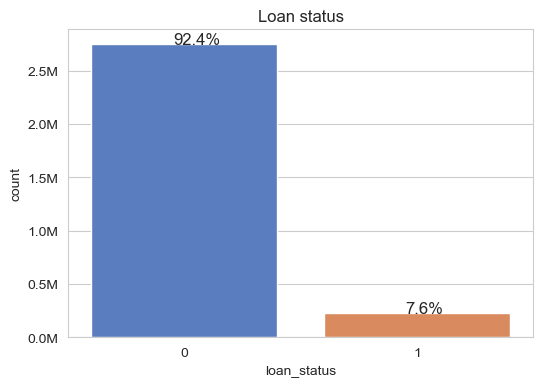

In [8]:
def y_axis_millions(axis: plt.Axes) -> plt.Axes:
    """
    Converts Y axis expression to Mil
    """
    axis.set_yticklabels(['{:.1f}M'.format(yval/(10**6)) for yval in axis
                        .get_yticks()])
    return axis

def countplot_graph(dataframe: pd.DataFrame, 
                    variable: str, 
                    y_mil: bool) \
                    -> None:
    """
    Creates countplot of provided variable in dataframe, y-axis in mil
    Inputs:
    dataframe: dataframe containing data 
    variable (str): Variable of countplot
    y_mil (bool): If True, the y-axis format in millions.
    """
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=variable, data=dataframe)
    plt.title("Loan status")
    
    if y_mil:
        ax = y_axis_millions(ax)
    
    # Annotate the bars with their respective heights (counts) in percentage
    total = float(len(dataframe))
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

    plt.show()

countplot_graph(sample_df,'loan_status', y_mil=True)

We can see that we have very imbalanced data, with just 7.6% of loans 
classified as positive. For further investigation, we should get familiar with 
our data more. The next thing we can examine is trends and changes over time.

FixedFormatter should only be used together with FixedLocator


<Figure size 800x400 with 0 Axes>

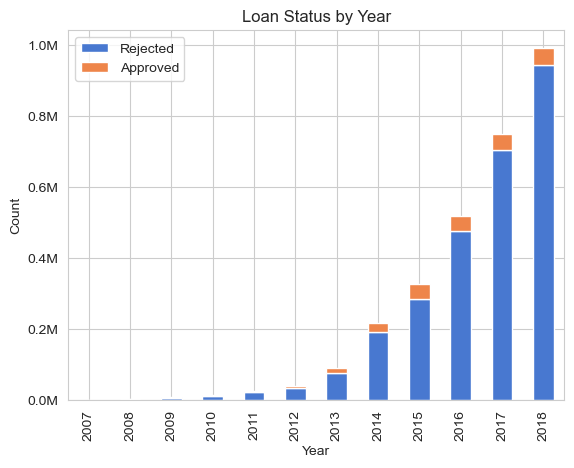

In [5]:
crosstab_df = pd.crosstab(sample_df['year_issue'], sample_df['loan_status'])
plt.figure(figsize=(8, 4))
ax = crosstab_df.plot(kind='bar', stacked=True)
ax = y_axis_millions(ax)
plt.title('Loan Status by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['Rejected', 'Approved'])
plt.show();


In the graph above, we observe a rapid annual increase in the total number of 
loans. However, the proportion of approved to rejected loans seems to reduce 
over time. While the total volume of loans has increased substantially, the 
number of approved loans in the past four years appears to remain constant.


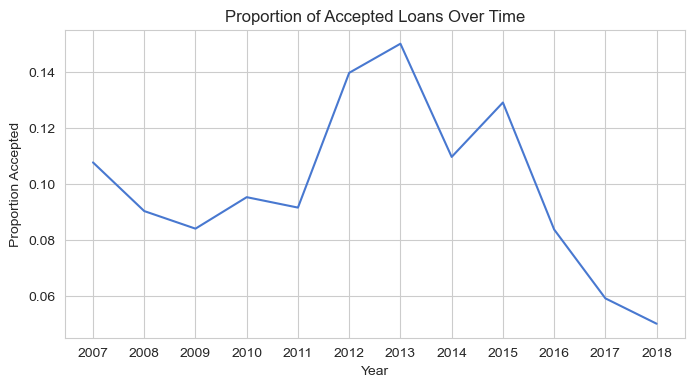

In [6]:
# Calculate the proportion of accepted loans
crosstab_df['proportion_accepted'] = crosstab_df[1] / (crosstab_df[0] 
                                                       + crosstab_df[1])

# Plot the proportion of accepted loans over time
plt.figure(figsize=(8, 4))
ax1 = sns.lineplot(x=crosstab_df.index,
                  y='proportion_accepted',
                  data=crosstab_df)
ax1.set_xticks(crosstab_df.index)
ax1.set_title('Proportion of Accepted Loans Over Time')
ax1.set_ylabel('Proportion Accepted')
ax1.set_xlabel('Year')
plt.show();

We observe that the proportion of accepted loans increased from 9% to 15% up 
until the year 2013. After this year, the approval rate dropped to 5% by 2018. 
This trend might indicate a tightening of lending standards, changes in 
economic conditions, or both. It would be beneficial to examine how the lending 
season behaviors of individuals change throughout the year.


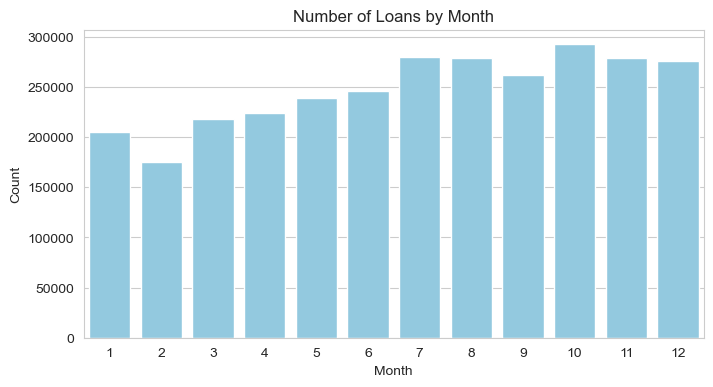

In [7]:
plt.figure(figsize=(8, 4))
ax3 = sns.countplot(x='month_issue', 
                   data=sample_df, 
                   color='skyblue', 
                   order = sorted(sample_df['month_issue'].unique()))
ax3.set_title('Number of Loans by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('Count')
plt.show()


Monthly loan distribution shows a seasonal pattern. There we can see the number 
of loans was in February and peaked in October.

Next, we'll investigate any geographic distribution of loan applies.

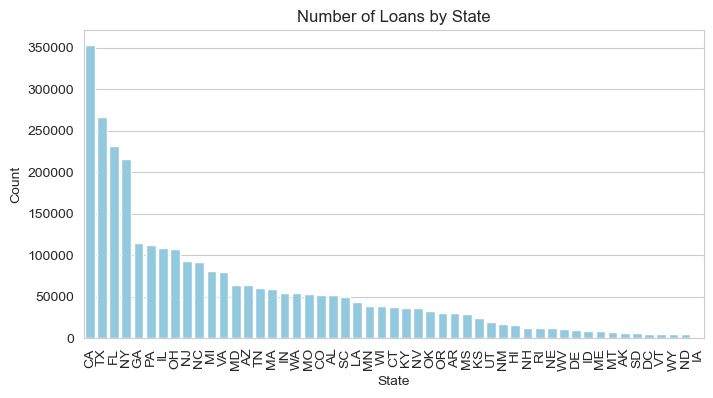

In [8]:
plt.figure(figsize=(8, 4))
ax1 = sns.countplot(x='state',
                   data=sample_df,
                   color='skyblue',
                   order = sample_df['state'].value_counts().index)
ax1.set_title('Number of Loans by State')
ax1.set_xlabel('State')
ax1.set_ylabel('Count')
ax1.set_xticks(rotation=90)
plt.show()


We can see that most loans were in California, Texas, Florida and New York 
state. Let's visualize it in heatmap.

In [9]:
state_counts = sample_df['state'].value_counts().reset_index()

state_counts.columns = ['state_code', 'loan_count']

fig = px.choropleth(state_counts,
                    locations='state_code',
                    locationmode="USA-states",
                    scope="usa",
                    color='loan_count',
                    color_continuous_scale="Viridis_r",
                    hover_name='state_code',
                    title='Heat map of loan counts in each state'
                    )
fig.show()


In [10]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/3/34/U.S._states_and_territories_by_population_density.svg", 
      width=700, height=400)


From these heatmaps, we can see that the number of loans is correlated to people 
population in the state. The number of loans does not paint the entire picture. 
Next thing to check loan amount correlation to loan status. 

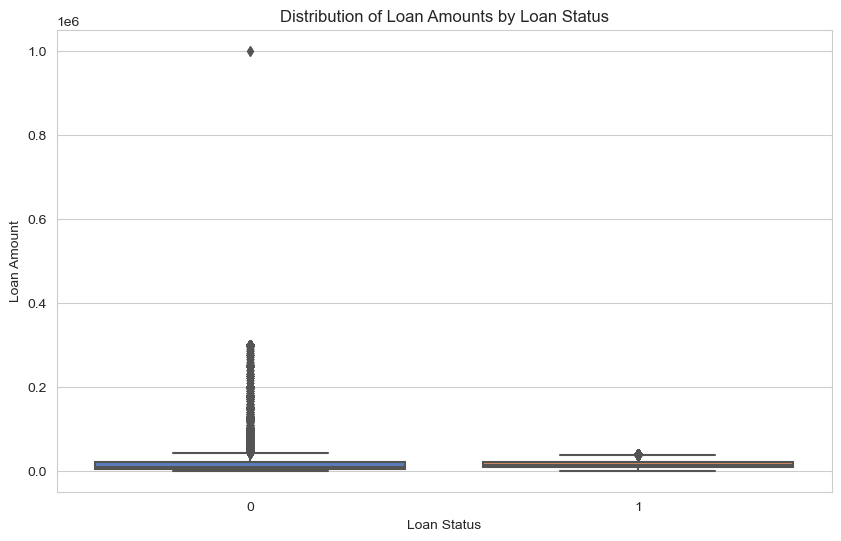

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=sample_df)
plt.title('Distribution of Loan Amounts by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.show()


We can see there are some extreme values in rejected instances. We can 
remove instances above 3 standard deviations, to remove about 0.3% of data, 
to better visualize distribution.

In [12]:
before_df = sample_df.groupby('loan_status')['loan_amnt'].describe()

# Calculate z-scores
sample_df['z_score'] = zscore(sample_df['loan_amnt'])
df_after = sample_df[abs(sample_df['z_score']) < 3]

after_df = df_after.groupby('loan_status')['loan_amnt'].describe()

before_df

count     mean      std    min     25%      50%      75%  \
loan_status                                                                 
0           2748832.00 13099.35 14859.70  75.00 4700.00 10000.00 20000.00   
1            225895.00 15039.50  9175.03 500.00 8000.00 12850.00 20000.00   

                   max  
loan_status             
0           1000000.00  
1             40000.00

In [13]:
after_df

count     mean      std    min     25%      50%      75%  \
loan_status                                                                 
0           2736855.00 12517.17 10774.93  75.00 4500.00 10000.00 20000.00   
1            225895.00 15039.50  9175.03 500.00 8000.00 12850.00 20000.00   

                 max  
loan_status           
0           56775.00  
1           40000.00

After removing extreme values, our means of rejected values dropped by 500, and
 we can observe a standard deviation drop by 4085. Other values kept almost 
 the same.

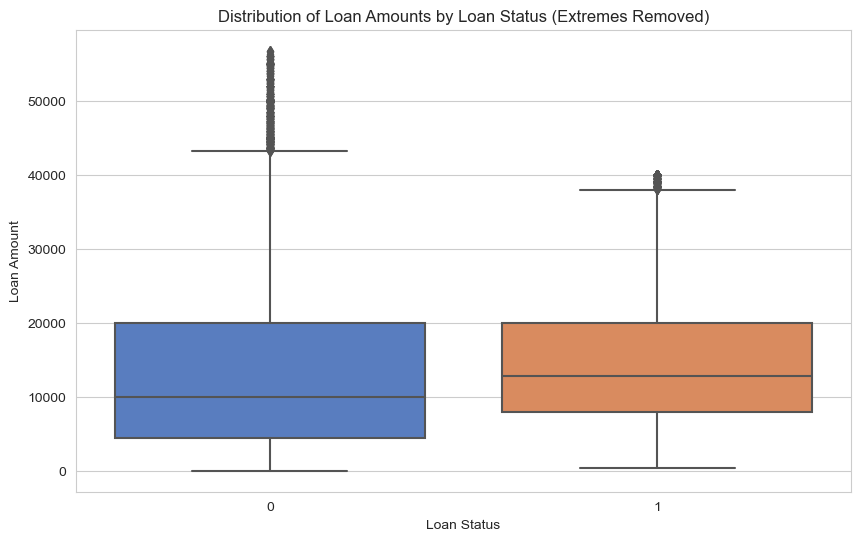

In [14]:
# Now you can plot the filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=df_after)
plt.title('Distribution of Loan Amounts by Loan Status (Extremes Removed)')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.show()

sample_df = sample_df.drop('z_score', axis=1)

We can observe that standard deviation of rejected loans is higher. People 
asking for higher loan amounts could have a higher chance of getting accepted,
 but extreme loan amount requests are usually rejected. Insights are 
 observational do not imply causation. Further analysis would be needed to 
 find more factors that can have an impact on loan acceptance. Another 
 financial factor is debt to an income ratio. 

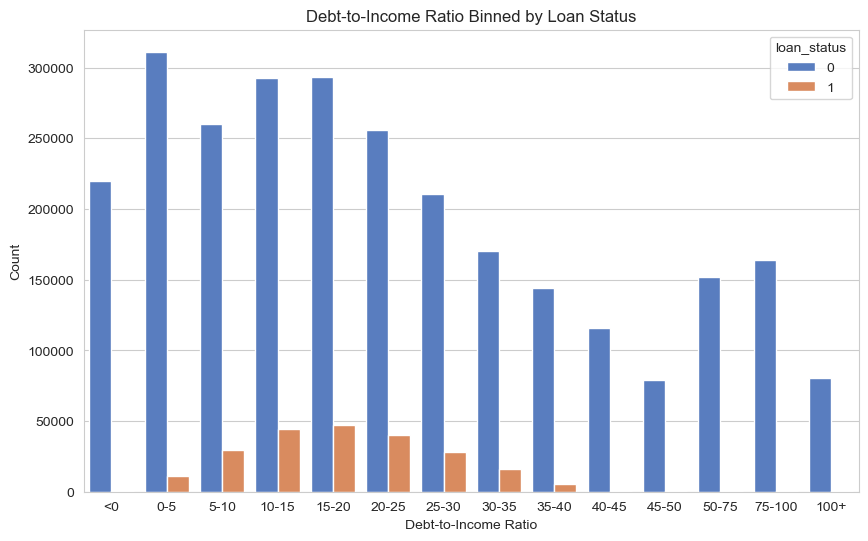

In [15]:
bins = [-np.inf,0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75,100, np.inf]
labels = ['<0', '0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', 
          '35-40', '40-45', '45-50', '50-75','75-100', '100+']

sample_df['dti_binned'] = pd.cut(sample_df['debt_to_income'], 
                                          bins=bins, 
                                          labels=labels)

# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=sample_df, x='dti_binned', hue='loan_status')
plt.title('Debt-to-Income Ratio Binned by Loan Status')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Count')
plt.show()


There are some negative DTI values. While there are a lot of negative DTI 
values, we assume it is like missing data. These individuals don't have risk 
score as well. The loan approval seems higher in the bins with lower DTI 
from 5-10% to 25-30. There is a noticeable drop in approval rates from 40-45%
bins. For extremely high DTI rations (over 50%) almost all loans are 
rejected and indicate higher risk for the lender. 

As we saw earlier, there are a lot of missing values in risk score, but we 
should check it anyway to see if there are correlations in that 

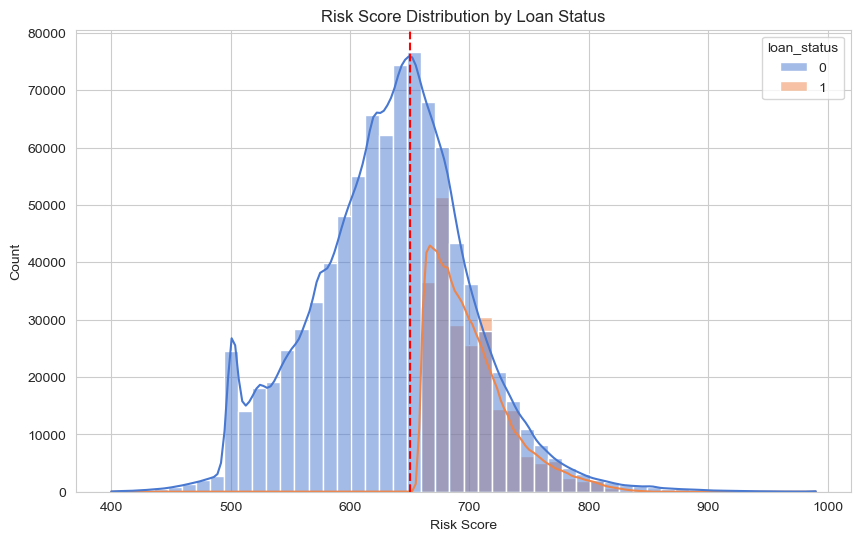

In [16]:
# removing NaN values and less than 400 to get a clearer view of distribution
sample_df_risk = sample_df[(sample_df['risk_score'].notna()) \
                           & (sample_df['risk_score'] >= 400)]

plt.figure(figsize=(10,6))
sns.histplot(data=sample_df_risk, 
             x='risk_score', 
             hue='loan_status', 
             bins=50, 
             kde=True)
plt.axvline(650, color='red', linestyle='--')
plt.title('Risk Score Distribution by Loan Status')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.show()


After removal of NaN risk scores, we observe nearly all applications below
a 650 risk score were rejected. This suggests a potential critical threshold
for loan approval. The ratio of accepted loans significantly rises after 650.
However, beyond an 850 risk score, almost all loans are rejected. Overall,
the risk score provides vital insights into loan status and should be
considered in model prediction.

Next, we'll look into 'employment length.' How does this attribute factor into 
the loan distribution?

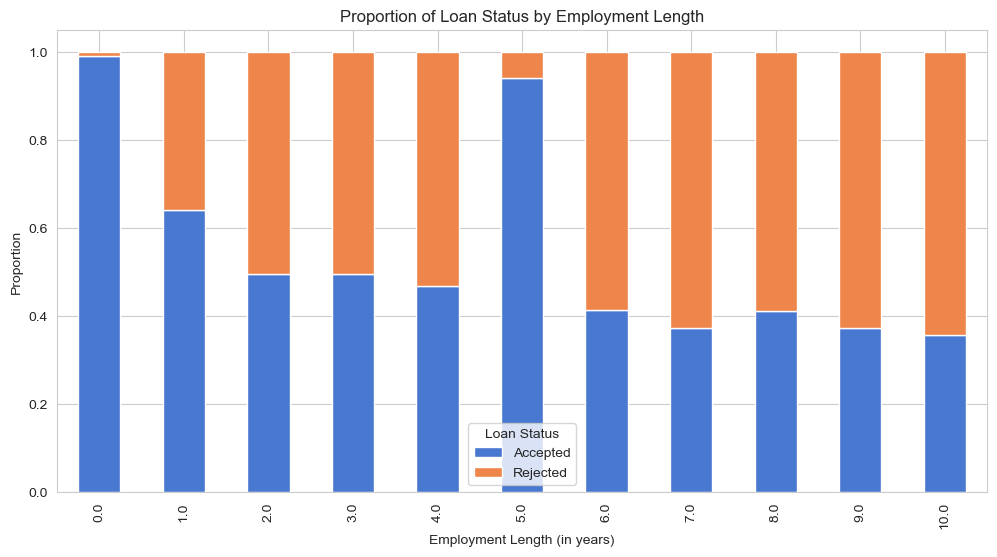

In [17]:
emp_replace = {'< 1 year': 0, '1 year': 1, '2 years': 2,
               '3 years': 3, '4 years': 4, '5 years': 5,
               '6 years': 6, '7 years': 7, '8 years': 8,
               '9 years': 9, '10+ years': 10}
sample_df['emp_length'] = sample_df['emp_length'].replace(emp_replace)

# Calculate proportions
df_proportion = (sample_df.groupby('emp_length')['loan_status']
                 .value_counts(normalize=True)
                 .unstack())

# Plot
df_proportion.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Proportion of Loan Status by Employment Length')
plt.xlabel('Employment Length (in years)')
plt.ylabel('Proportion')
plt.legend(title='Loan Status', labels=['Accepted', 'Rejected'])

plt.show();


In proportion graph, we can see that people who work in the same place at 
least 1 year have a much higher chance to get a loan. Over years of experience
 we can observe that probability has a tendency to increase. In 5year we can 
 see unexpected value of proportions and it is very low. Tried to do several 
 graphs to explain this anomaly, but didn't get any strong insights.
 
Let's check how features correlated to each other

C:\Users\GV\AppData\Local\Temp\ipykernel_10924\2880606062.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



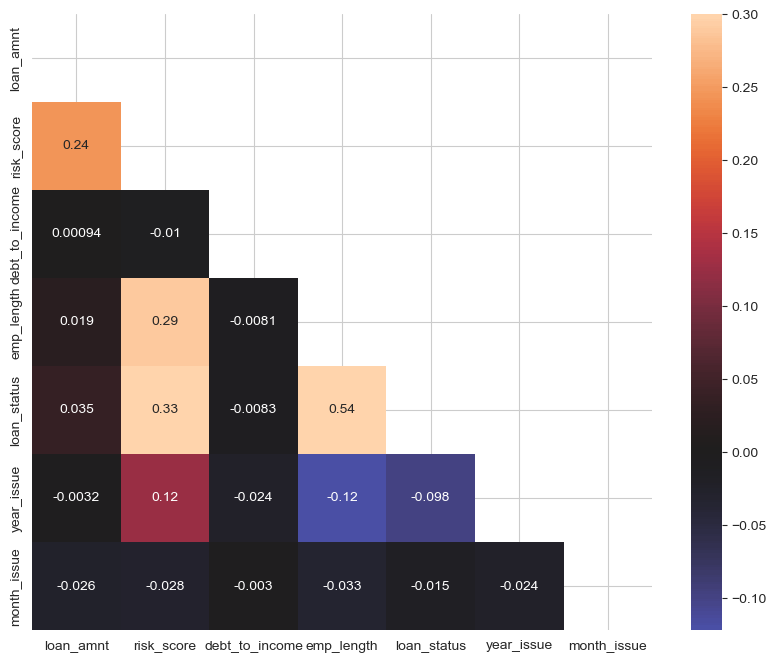

In [18]:
# Compute the correlation matrix
corr = sample_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, vmax=.3, center=0, annot=True)

plt.show();



From the heatmap, several observations can be made:

* Risk score and loan status share a positive correlation. This suggests that 
  a higher risk score corresponds to a higher likelihood of loan acceptance.
* Employment length and loan status demonstrate the strongest correlation 
  (coefficient of 0.54). Individuals who've maintained employment at the 
  same place for a longer duration are more likely to have their loans 
  approved.
* There's a minor positive correlation between risk score and employment 
  length.
* Debt-to-Income (DTI) ratio shows little to no correlation with other 
  factors.

As emp_length and risk_score can have an impact on loan_status, we should check
 the correlation between them


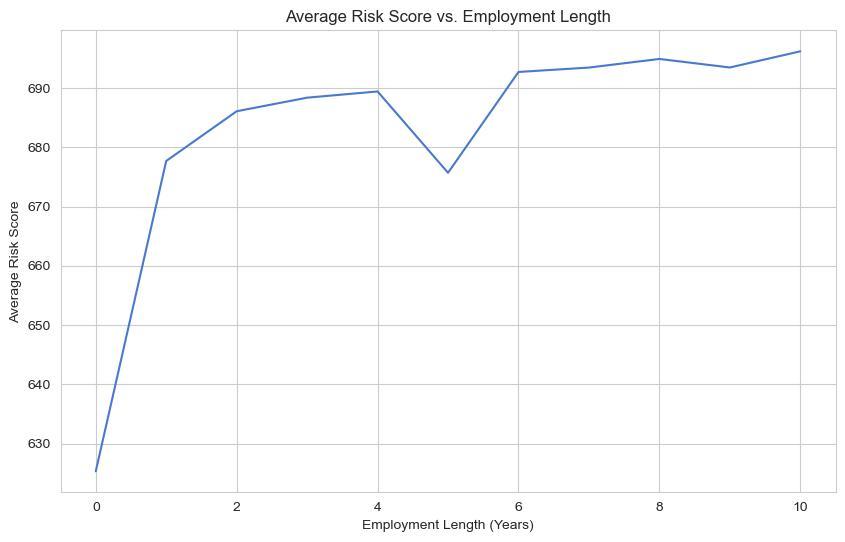

In [19]:
plt.figure(figsize=(10, 6))

average_scores_df = sample_df.groupby(['emp_length'])['risk_score'].mean().reset_index()

# Plotting
sns.lineplot(data=average_scores_df,
             x='emp_length',
             y='risk_score',
             markers=True)

# Update title and axes labels
plt.title('Average Risk Score vs. Employment Length')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Average Risk Score')
plt.grid(True)

plt.show()


The risk score notably rises after one year of employment. After that, risk 
scores increase slightly every year. An anomaly is visible in the 5-year 
employment status where the average risk score dips.

The last thing that can have impact is loan title, to see what causes people
 to get a loan.

In [20]:
# Replace '_' with ' ' and convert to lowercase
sample_df['title'] = sample_df['title'].str.replace('_', ' ').str.lower()
sample_df.title.value_counts().head(30)

debt consolidation           1341775
other                         478980
credit card refinancing       276589
credit card                   135824
home improvement              132674
major purchase                 99794
car financing                  77521
car                            52550
home buying                    50460
medical expenses               41415
moving                         38182
medical                        35764
moving and relocation          32902
business loan                  32190
vacation                       32069
small business                 31307
business                       23405
house                          18438
renewable energy                3182
green loan                      2663
wedding                         1857
                                1487
consolidation                   1074
personal loan                    685
debt consolidation loan          654
credit card consolidation        469
personal                         458
c

In [2]:
def categorize_title(title: str) -> str:
    """
    Converts title to one of the most common categories.
    """
    if title is None:
        return 'other'
    else:
        if 'consolidation' in title:
            return 'debt consolidation'
        elif 'credit' in title:
            return 'credit card'
        elif 'car' in title:
            return 'car'
        elif 'home' in title:
            return 'home'
        elif 'business' in title:
            return 'business'
        elif 'major purchase' in title:
            return 'major purchase'
        elif 'medical' in title:
            return 'medical'
        elif 'vacation' in title:
            return 'vacation'
        elif 'moving' in title:
            return 'moving'
        else:
            return 'other'

In [22]:
sample_df['title'] = sample_df['title'].apply(categorize_title)

sample_df.title.value_counts().head(100)

debt consolidation    1346316
other                  528522
credit card            416365
home                   184260
car                    131037
major purchase          99845
business                87555
medical                 77384
moving                  71283
vacation                32160
Name: title, dtype: int64

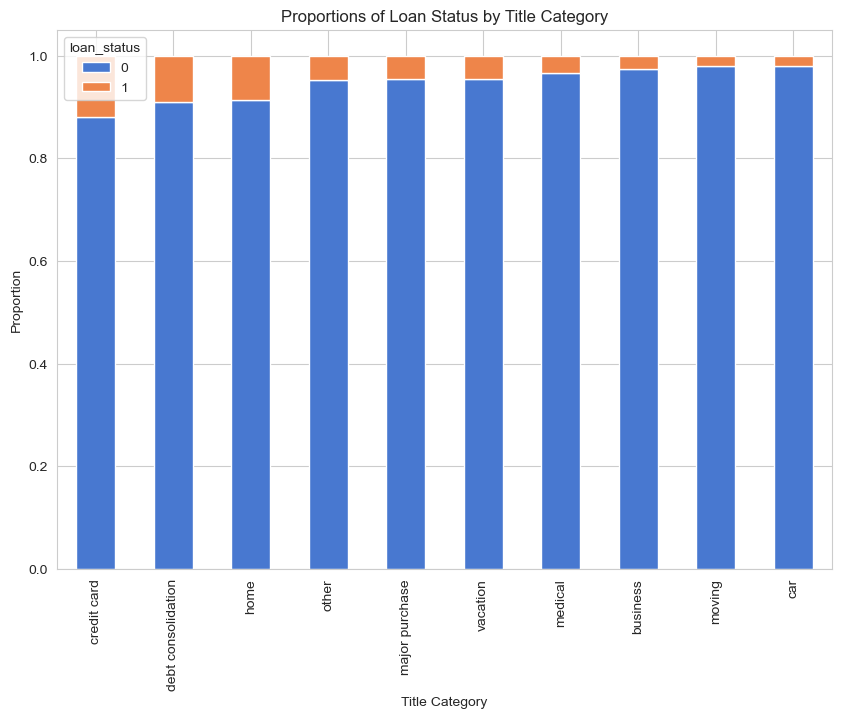

In [35]:
title_loan_status = pd.crosstab(sample_df['title'], 
                                sample_df['loan_status'], 
                                normalize='index')

title_loan_status = title_loan_status.sort_values(by=1, ascending=False)

title_loan_status.plot(kind='bar', 
                       stacked=True, 
                       figsize=(10, 7))
plt.title("Proportions of Loan Status by Title Category")
plt.ylabel('Proportion')
plt.xlabel('Title Category')
plt.show()


From the graph above, we can see that most chances of approving got loans with 
title category credit card, debt consolidation and home

# 3. Predicting Loan Status

## Feature engineering

Since we have very imbalanced data, and there are a lot of missing values in 
risk_score which is an important factor, we eliminate all rows with missing 
values. 

In [10]:
loans_df = dd.read_parquet('loans_df.parquet', engine='pyarrow', npartitions=3)
loans_df_filtered = loans_df.dropna().compute()
loans_df_filtered.shape

(11066128, 11)

There are some DTI values less than 0 which is not possible. We should 
eliminate them as well

In [11]:
loans_df_filtered = loans_df_filtered[loans_df_filtered['debt_to_income']>0]
loans_df_filtered.shape

(10615208, 11)

FixedFormatter should only be used together with FixedLocator


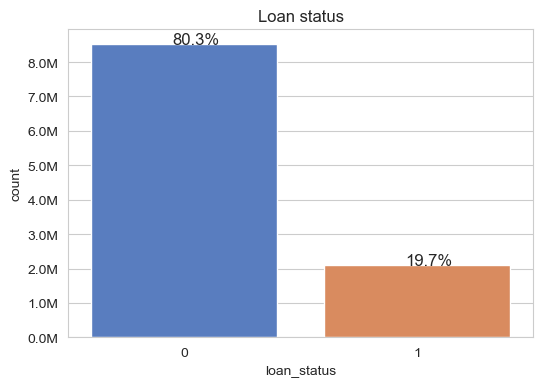

In [9]:
countplot_graph(loans_df_filtered,'loan_status', y_mil=True)

We can see that we have very imbalanced data with 4:1 ratio. 

In [10]:
# Categorize title to main categories
loans_df_filtered['title'] = loans_df_filtered['title'].apply(categorize_title)

As there are a lot of zip codes, we will keep just first 2 digits of it, to 
reduce dimensionality, and keep some information about location.

In [0]:
loans_df_filtered['zip_code'] = (loans_df_filtered.zip_code
                                 .apply(lambda x:str(x)[0:2]))
loans_df_filtered.drop(['date_issue'], axis=1, inplace=True)

# Get features and target
X = loans_df_filtered.drop('loan_status', axis=1)
y = loans_df_filtered['loan_status']

In [2]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Mutual information scores"""
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, 
                                    y, 
                                    discrete_features=discrete_features, 
                                    random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    """Plotting mutual information scores"""
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    # Add the data value on each bar
    for idx, value in enumerate(scores.sort_values()):
        plt.text(value, idx, f'{value:.3f}', va='center')
    plt.show()

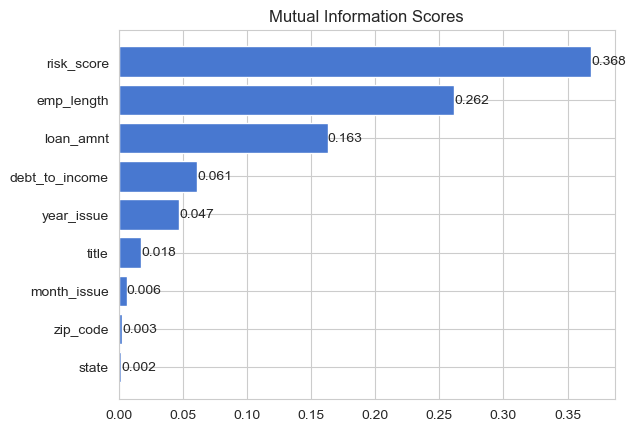

In [39]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

As state, zip_code and month_issue don't have a strong relationship with 
target feature and have a lot of categorical values I decided to remove them.

In [0]:
loans_df_filtered.drop(['state','zip_code','month_issue'], axis=1, inplace=True)

In [14]:
X = loans_df_filtered.drop('loan_status', axis=1).compute()
y = loans_df_filtered['loan_status'].compute()
# Splitting dataset to training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,
                                                    stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                stratify=y_temp)
# Taking smaller sample for model selection part and validation
X_select_train, _, y_select_train, _ = train_test_split(X_train, y_train,
                                                        test_size=0.95,
                                                        stratify=y_train)

X_select_val, _, y_select_val, _ = train_test_split(X_val, y_val,
                                                    test_size=0.95,
                                                    stratify=y_val)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("X_select_train shape: ", X_select_train.shape)
print("X_select_val shape: ", X_select_val.shape)

X_train shape:  (7430645, 6)
X_val shape:  (1592281, 6)
X_test shape:  (1592282, 6)
X_select_train shape:  (371532, 6)
X_select_val shape:  (79614, 6)


In [15]:
X_train.head()

loan_amnt               title  risk_score  debt_to_income  \
790223    31200.000                 car     727.000          10.720   
13322463   1000.000                 car     597.000           5.860   
21859386   2000.000            business     616.000          16.430   
24864105  10000.000  debt consolidation     675.000          30.990   
13262989   8000.000  debt consolidation     573.000          27.520   

         emp_length  year_issue  
790223      3 years        2018  
13322463    5 years        2017  
21859386   < 1 year        2015  
24864105   < 1 year        2017  
13262989   < 1 year        2017

In [14]:
# create pipelines for data preprocessor and model selection.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)

In [15]:
# Selecting numeric and categorical features. Assigning them to preprocessor
# pipeline.
numeric_features = ['loan_amnt', 'risk_score', 'debt_to_income']
categorical_features = ['title', 'emp_length', 'year_issue']
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

After that, we need to write a list of classifiers that we want to train and
make a loop for training them and making dataframe of their metrics.

In [7]:
classifiers = [
    LogisticRegression(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    DecisionTreeClassifier(),
    BaggingClassifier(n_jobs=-1),
    AdaBoostClassifier(), 
    GradientBoostingClassifier(), 
    XGBClassifier(eval_metric='auc', n_jobs=-1),
    LGBMClassifier(n_jobs=-1),
    CatBoostClassifier(verbose=False, task_type="CPU", thread_count=-1)  
]

results = []

for classifier in classifiers:
    start_time = time.time()

    # Define the pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("undersample", RandomUnderSampler(sampling_strategy='majority')),
            ("classifier", classifier),
        ]
    )

    # Fit and predict
    model = pipeline.fit(X_select_train, y_select_train)
    predictions = model.predict(X_select_val)
    probabilities = model.predict_proba(X_select_val)[:, 1] # for roc_auc_score

    end_time = time.time()

    # Compute metrics
    accuracy = accuracy_score(y_select_val, predictions)
    precision = precision_score(y_select_val, predictions)
    recall = recall_score(y_select_val, predictions)
    f1 = f1_score(y_select_val, predictions)
    roc_auc = roc_auc_score(y_select_val, probabilities)
    time_elapsed = end_time - start_time

    results.append({
        'Classifier': type(classifier).__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC AUC': roc_auc,
        'Time (s)': time_elapsed
    })
    print(type(classifier).__name__ + ' trained successfully in '
          + f"{time_elapsed:.3f}" + ' s')

results_df = pd.DataFrame(results)

results_df


LogisticRegression trained successfully in 14.054 s
RandomForestClassifier trained successfully in 57.058 s
DecisionTreeClassifier trained successfully in 9.877 s
BaggingClassifier trained successfully in 22.906 s
AdaBoostClassifier trained successfully in 11.616 s
GradientBoostingClassifier trained successfully in 31.997 s
XGBClassifier trained successfully in 7.783 s
LGBMClassifier trained successfully in 2.892 s
CatBoostClassifier trained successfully in 36.377 s


Classifier  Accuracy  Precision  Recall   F1  ROC AUC  \
0          LogisticRegression      0.92       0.73    0.92 0.82     0.97   
1      RandomForestClassifier      0.94       0.80    0.96 0.87     0.99   
2      DecisionTreeClassifier      0.95       0.82    0.95 0.88     0.95   
3           BaggingClassifier      0.96       0.85    0.96 0.90     0.99   
4          AdaBoostClassifier      0.94       0.79    0.95 0.87     0.99   
5  GradientBoostingClassifier      0.94       0.80    0.95 0.87     0.99   
6               XGBClassifier      0.98       0.90    0.99 0.94     1.00   
7              LGBMClassifier      0.97       0.89    0.99 0.94     1.00   
8          CatBoostClassifier      0.98       0.90    0.99 0.94     1.00   

   Time (s)  
0     14.05  
1     57.06  
2      9.88  
3     22.91  
4     11.62  
5     32.00  
6      7.78  
7      2.89  
8     36.38

In [11]:
oversampling_results = pd.read_csv('model selection oversample.csv', 
                                   index_col=0)
oversampling_results

Classifier  Accuracy  Precision  Recall   F1  ROC AUC  \
0          LogisticRegression      0.92       0.74    0.92 0.82     0.97   
1      RandomForestClassifier      0.95       0.83    0.94 0.88     0.99   
2      DecisionTreeClassifier      0.94       0.83    0.89 0.86     0.92   
3           BaggingClassifier      0.95       0.86    0.92 0.89     0.98   
4          AdaBoostClassifier      0.94       0.79    0.95 0.86     0.98   
5  GradientBoostingClassifier      0.94       0.80    0.95 0.87     0.99   
6               XGBClassifier      0.97       0.90    0.97 0.93     1.00   
7              LGBMClassifier      0.96       0.84    0.97 0.90     0.99   
8          CatBoostClassifier      0.97       0.88    0.97 0.93     1.00   

   Time (s)  
0     98.78  
1    550.84  
2    135.28  
3    231.56  
4    125.39  
5    246.12  
6    116.05  
7     82.66  
8    231.53

After comparing undersampling and oversampling, we can see that 
undersampling is much faster and get better results. Best performing 
models were XGBClassifier, CatBoostClassifier, and LGBMClassifier. As we have
 a lot of data and computing time is an important factor, we will choose XGBC 
 and LGBMC for further hyperparameter tuning

In [10]:
param_grid_xgb = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 3),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.5, 0.5),
}

param_grid_lgbm = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 3),
    'classifier__max_depth': randint(3, 10),
    'classifier__num_leaves': randint(31, 248),
    'classifier__subsample': uniform(0.5, 0.5),
}


classifiers = [
    {"classifier": XGBClassifier(eval_metric='auc', n_jobs=-1), "param_grid": param_grid_xgb},
    {"classifier": LGBMClassifier(n_jobs=-1), "param_grid": param_grid_lgbm}
]

for clf in classifiers:
    start_time = time.time()
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("undersample", RandomUnderSampler(sampling_strategy='majority')),
            ("classifier", clf["classifier"]),
        ]
    )

    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=clf["param_grid"],
        scoring="roc_auc",
        n_iter=70,
        cv=3,
        n_jobs=-1,
        random_state=42,
    )

    randomized_search.fit(X_select_train, y_select_train)
    best_estimator = randomized_search.best_estimator_

    predictions = best_estimator.predict(X_select_val)
    probabilities = best_estimator.predict_proba(X_select_val)[:, 1]
    roc_auc = roc_auc_score(y_select_val, probabilities)
    end_time = time.time()

    print(clf["classifier"].__class__.__name__)
    print("ROC_AUC :", roc_auc)
    print("Time: ", end_time - start_time)
    print("Best parameters:", randomized_search.best_params_)
    print("***")


XGBClassifier
ROC_AUC : 0.9970873584240763
Time:  1412.84911942482
Best parameters: {'classifier__learning_rate': 0.37626386410202006, 'classifier__max_depth': 3, 'classifier__n_estimators': 330, 'classifier__subsample': 0.9534142207728771}
***
LGBMClassifier
ROC_AUC : 0.9970202034495782
Time:  367.3496103286743
Best parameters: {'classifier__learning_rate': 0.2212483925486317, 'classifier__max_depth': 4, 'classifier__n_estimators': 387, 'classifier__num_leaves': 205, 'classifier__subsample': 0.9950269250521316}
***


***
XGBClassifier
ROC_AUC : 0.9970873584240763
Time: 1412.84911942482
Best parameters: {'classifier__learning_rate': 0.37626386410202006, 'classifier__max_depth': 3, 'classifier__n_estimators': 330, 'classifier__subsample': 0.9534142207728771}
***
LGBMClassifier
ROC_AUC : 0.9970202034495782
Time:  367.3496103286743
Best parameters: {'classifier__learning_rate': 0.2212483925486317, 'classifier__max_depth': 4, 'classifier__n_estimators': 387, 'classifier__num_leaves': 205, 'classifier__subsample': 0.9950269250521316}
***
We get almost the same results of both classifiers, as LGBMC was faster, we 
choose it as our model. 

In [21]:
# Creating function, which creates confusion matrix
def conf_matrix_pred(y_test, y_pred):
    """
    Display a confusion matrix heatmap for the given ground truth labels and 
    predicted labels.
    
    Parameters:
    - y_test : Ground truth (correct) target values.
    
    - y_pred : Estimated target values returned by a classifier.
    
    Returns:
    None. This function directly visualizes the confusion matrix using a heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".0f",
        linewidths=0.5,
        cmap="Blues",
        square=True,
    )
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    all_sample_title = "Confusion matrix"
    plt.title(all_sample_title, size=15)
    plt.show()

LGBM Classifier:


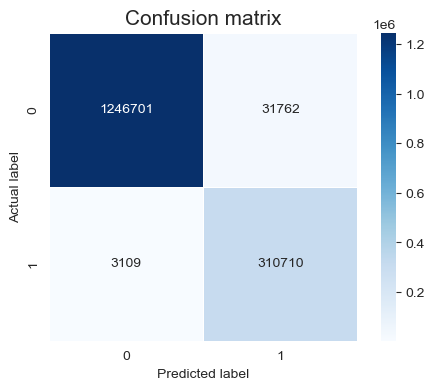


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1278463
           1       0.91      0.99      0.95    313819

    accuracy                           0.98   1592282
   macro avg       0.95      0.98      0.97   1592282
weighted avg       0.98      0.98      0.98   1592282


In [7]:
# LGBM pipeline with the best hyperparameters
pipeline_lgbm = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("undersample", RandomUnderSampler(sampling_strategy='majority')),
        ("classifier", LGBMClassifier(n_estimators=387,
                                      learning_rate=0.22,
                                      max_depth=4,
                                      num_leaves=205,
                                      subsample=0.995,
                                      n_jobs=-1,
                                      verbose=-1))
    ]
)

# Fit the pipeline using the concatenated training and validation data
lgbm_model = pipeline_lgbm.fit(X_train, y_train)

# Predict using the LGBM pipeline on the test set
lgbm_predictions = lgbm_model.predict(X_test)

# Display confusion matrix and classification report for LGBM
print("LGBM Classifier:")
conf_matrix_pred(y_test, lgbm_predictions)
print("\nClassification Report:\n",
      classification_report(y_test, lgbm_predictions, zero_division=0))

Our model gets overall 98% of accuracy, and 99% 95% of f1 scores which 
indicates that it has done well in predicting both classes. There are more 
FP values than FN we could adjust our threshold to get less money loss which 
should be discussed with a business team. 

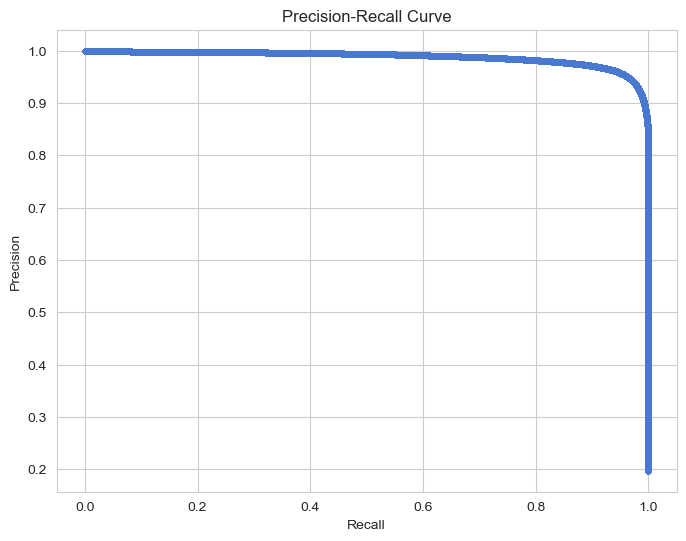

In [37]:
# Get the probabilities of the positive class
y_scores = lgbm_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall values
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

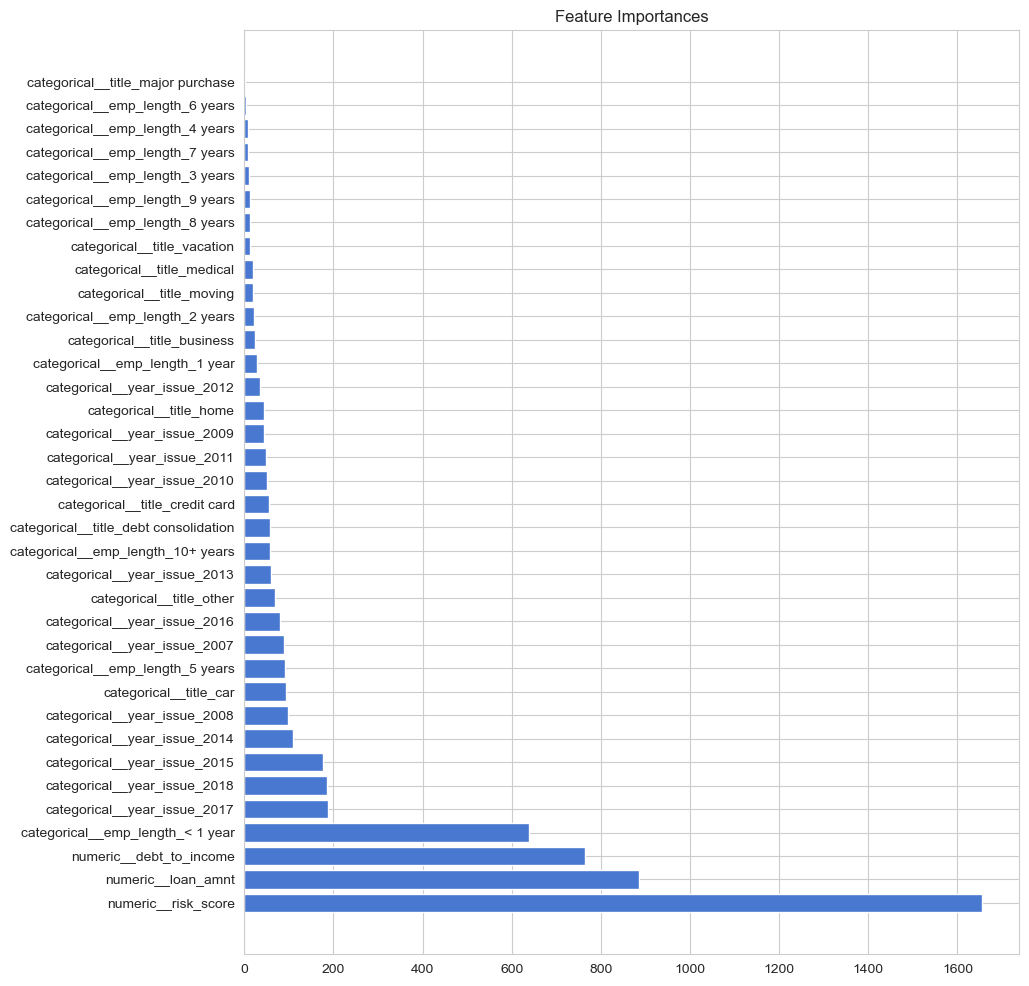

In [39]:
# Extract the LGBM classifier from the pipeline
classifier = lgbm_model.named_steps["classifier"]

# Get feature importances
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Get feature names from preprocessor in the pipeline
preprocessor = lgbm_model.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

# Plot the feature importances
plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.show();

In the graph above, we can see which features have the most impact on model 
predictions. These feature importances don't indicate whether they decrease or
 increase the predicted values.

In [8]:
# Save the model to a file
joblib.dump(lgbm_model, 'lgbm_loan_status.pkl')

['lgbm_loan_status.pkl']

## Auto Sklearn
Let's try the auto-sklearn model and compare results. To run auto-sklearn on 
windows machine, I used docker container.

import auto sklearn.classification
from sklearn.metrics import classification_report

#Initialize the classifier
automl = auto sklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60 * 30,
    per_run_time_limit=30 * 5)

#Fit model on training data
automl.fit(X_select_train_df, y_select_train_df)

#Predict on validation data using the best model
predictions_val = automl.predict(X_select_val_df)

#Generate the classification report for validation data
report_val = classification_report(y_select_val_df, predictions_val)

#Print the report for validation data
print("Auto-sklearn Classifier Validation Report:")
print(report_val)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     63923
           1       0.93      0.96      0.95     15691

    accuracy                           0.98     79614
    

LGBM Classifier:
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1278463
           1       0.91      0.99      0.95    313819

    accuracy                           0.98   1592282


We get quite good results just in 30mins. F1 score and accuracy of both groups
 is the same as our model. The Main difference in recall of accepted loans. If 
 we give the model more data and computation time, I think results 
 could be almost the same.  

# 4. Predicting Loan Grade

## Data Cleaning

In [32]:
accepted_df_full = pd.read_parquet('accepted_df_full_original.parquet')
print(accepted_df_full.shape)
accepted_df_full.head()

(2260701, 151)


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN   3600.000     3600.000         3600.000   36 months   
1  68355089        NaN  24700.000    24700.000        24700.000   36 months   
2  68341763        NaN  20000.000    20000.000        20000.000   60 months   
3  66310712        NaN  35000.000    35000.000        35000.000   60 months   
4  68476807        NaN  10400.000    10400.000        10400.000   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0    13.990      123.030     C        C4                      leadman   
1    11.990      820.280     C        C1                     Engineer   
2    10.780      432.660     B        B4                 truck driver   
3    14.850      829.900     C        C5  Information Systems Officer   
4    22.450      289.910     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years       MORTGAGE   55000.000        Not Verified  Dec-2015   
1  10+ years       MORTGAGE   65000.000        Not Verified  Dec-2015   
2  10+ years       MORTGAGE   63000.000        Not Verified  Dec-2015   
3  10+ years       MORTGAGE  110000.000     Source Verified  Dec-2015   
4    3 years       MORTGAGE  104433.000     Source Verified  Dec-2015   

  loan_status pymnt_plan                                                url  \
0  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
1  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
2  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
3     Current          n  https://lendingclub.com/browse/loanDetail.acti...   
4  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   

   desc             purpose               title zip_code addr_state    dti  \
0  None  debt_consolidation  Debt consolidation    190xx         PA  5.910   
1  None      small_business            Business    577xx         SD 16.060   
2  None    home_improvement                None    605xx         IL 10.780   
3  None  debt_consolidation  Debt consolidation    076xx         NJ 17.060   
4  None      major_purchase      Major purchase    174xx         PA 25.370   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0        0.000         Aug-2003         675.000          679.000   
1        1.000         Dec-1999         715.000          719.000   
2        0.000         Aug-2000         695.000          699.000   
3        0.000         Sep-2008         785.000          789.000   
4        1.000         Jun-1998         695.000          699.000   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0           1.000                  30.000                     NaN     7.000   
1           4.000                   6.000                     NaN    22.000   
2           0.000                     NaN                     NaN     6.000   
3           0.000                     NaN                     NaN    13.000   
4           3.000                  12.000                     NaN    12.000   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0    0.000   2765.000      29.700     13.000                   w      0.000   
1    0.000  21470.000      19.200     38.000                   w      0.000   
2    0.000   7869.000      56.200     18.000                   w      0.000   
3    0.000   7802.000      11.600     17.000                   w  15897.650   
4    0.000  21929.000      64.500     35.000                   w      0.000   

   out_prncp_inv  total_pymnt  total_pymnt_inv  total_rec_prncp  \
0          0.000     4421.724         4421.720         3600.000   
1          0.000    25679.660        25679.660        24700.000   
2          0.000    22705.924        22705.920        20000.000   
3      15897.650    31464.010        31464.010        19102.350   
4          0.000  

In [33]:
# Instant removing irrelevant features
accepted_df_full.drop(['id', 'member_id', 'url'], axis=1,
                      inplace=True)

In [33]:
missing_values = accepted_df_full.isna().sum().sort_values(ascending=False)
missing_values

orig_projected_additional_accrued_interest    2252050
hardship_end_date                             2249784
hardship_start_date                           2249784
hardship_type                                 2249784
hardship_reason                               2249784
                                               ...   
out_prncp                                          33
initial_list_status                                33
revol_bal                                          33
fico_range_high                                    33
loan_amnt                                          33
Length: 148, dtype: int64

In [34]:
# Compute 'purpose' column and replace which has less than 10k
value_counts = accepted_df_full['purpose'].value_counts()
to_replace = value_counts[value_counts < 10000].index
accepted_df_full['purpose'] = (accepted_df_full['purpose']
                               .replace(to_replace, 'other'))

# As the purpose is more relevant than title, we can remove it
accepted_df_full.drop('title', axis=1, inplace=True)

In [35]:
# Find columns with more than 150k missing values and remove them
columns_to_drop = missing_values[missing_values > 150000].index

print("Columns to be dropped:")
print(columns_to_drop)

accepted_df = accepted_df_full.drop(columns_to_drop, axis=1)

# Create extra feature where emp_length values were missing
accepted_df['emp_nan'] = accepted_df['emp_length'].isna().astype(int)

# Calculate the mode of the 'emp_length' column and fill nan values
mode = accepted_df['emp_length'].mode()[0]
accepted_df['emp_length'].fillna(mode, inplace=True)


Columns to be dropped:
Index(['orig_projected_additional_accrued_interest', 'hardship_end_date',
       'hardship_start_date', 'hardship_type', 'hardship_reason',
       'hardship_status', 'deferral_term', 'hardship_amount',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'hardship_loan_status', 'hardship_dpd', 'hardship_length',
       'payment_plan_start_date', 'settlement_term',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage',
       'sec_app_mths_since_last_major_derog', 'sec_app_revol_util',
       'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc',
       'sec_app_chargeoff_within_12_mths', 'sec_app_open_act_il',
       'sec_app_num_rev_accts', 'sec_app_collections_12_mths_ex_med',
       'verification_status_joint', 'dti_joint', 'annual_inc_jo

In [36]:
# remove missing values and duplicates
accepted_df.dropna(inplace=True)
accepted_df = accepted_df.drop_duplicates()

In [37]:
accepted_df.shape

(2092229, 88)

After cleaning our dataset, we lost about 10% of our data.

## Feature Selection

In [38]:
# Removing quasi-constant and constant features where 99% of data is constant
sel = DropConstantFeatures(tol=0.99, variables=None, missing_values='raise')
sel.fit(accepted_df)
print(f'Quasi-constant features will be dropped: {sel.features_to_drop_}')
accepted_df = sel.transform(accepted_df)

Quasi-constant features will be dropped: ['pymnt_plan', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_tl_30dpd', 'hardship_flag']


In [11]:
# Find and remove duplicated columns
sel = DropDuplicateFeatures(variables=None, missing_values='raise')
sel.fit(accepted_df)
print(f'Duplicated features will be dropped: {sel.features_to_drop_}')
accepted_df = sel.transform(accepted_df)

Duplicated features will be dropped: set()


In [39]:
# Creating few columns that can be beneficial
accepted_df['fico_change'] = accepted_df['fico_range_high'] \
                         - accepted_df['last_fico_range_low']
accepted_df['issue_month'] = pd.to_datetime(accepted_df['issue_d']).dt.month
accepted_df.drop('issue_d', axis=1, inplace=True)

In [40]:
accepted_df.shape

(2092229, 82)

In [ ]:
X = accepted_df.drop(['grade', 'sub_grade', 'int_rate'], axis=1)
y = accepted_df['grade']

# Splitting dataset to training, validation, and test sets
X_train_grade, X_temp, y_train_grade, y_temp = train_test_split(X, y, 
                                                                test_size=0.3,
                                                                stratify=y)
X_val_grade, X_test_grade, y_val_grade, y_test_grade = (train_test_split
                                                        (X_temp,
                                                         y_temp,
                                                         test_size=0.5,
                                                         stratify=y_temp))

print("X_train_grade shape: ", X_train_grade.shape)
print("X_val_grade shape: ", X_val_grade.shape)
print("X_test_grade shape: ", X_test_grade.shape)


In [43]:
# correlation selector of features pearson correlation more than 0.7
sel = SmartCorrelatedSelection(
    variables=None, 
    method="pearson",
    threshold=0.7,
    selection_method="variance"
)

sel.fit(X_train_grade, y_train_grade)

SmartCorrelatedSelection(selection_method='variance', threshold=0.7)

In [44]:
sel.correlated_feature_sets_

[{'funded_amnt', 'funded_amnt_inv', 'installment', 'loan_amnt'},
 {'fico_range_high', 'fico_range_low'},
 {'num_op_rev_tl', 'num_sats', 'open_acc', 'total_acc'},
 {'pub_rec', 'tax_liens'},
 {'revol_bal', 'total_rev_hi_lim'},
 {'bc_util', 'percent_bc_gt_75', 'revol_util'},
 {'out_prncp', 'out_prncp_inv'},
 {'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp'},
 {'collection_recovery_fee', 'recoveries'},
 {'fico_change', 'last_fico_range_high', 'last_fico_range_low'},
 {'avg_cur_bal', 'tot_cur_bal', 'tot_hi_cred_lim'},
 {'acc_open_past_24mths', 'num_tl_op_past_12m'},
 {'bc_open_to_buy', 'total_bc_limit'},
 {'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_rev_tl_bal_gt_0'},
 {'num_bc_tl', 'num_rev_accts'},
 {'total_bal_ex_mort', 'total_il_high_credit_limit'}]

In [45]:
feat_drop_grade = sel.features_to_drop_
print(f'Features to be dropped: {sel.features_to_drop_}')

# Remove features from all datasets
X_train_grade = sel.transform(X_train_grade)
X_val_grade = sel.transform(X_val_grade)
X_test_grade = sel.transform(X_test_grade)

print("X_train shape: ", X_train_grade.shape)


Features to be dropped: ['funded_amnt', 'funded_amnt_inv', 'installment', 'fico_range_low', 'open_acc', 'revol_bal', 'revol_util', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'last_fico_range_high', 'tot_cur_bal', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'tax_liens', 'total_il_high_credit_limit', 'fico_change']
X_train shape:  (1464560, 53)


In [8]:
mi_scores = make_mi_scores(X_train_grade, y_train_grade)

In [9]:
mi_scores

last_pymnt_amnt              0.612
out_prncp                    0.312
total_rec_int                0.308
total_pymnt                  0.272
fico_range_high              0.126
last_fico_range_low          0.091
term                         0.080
percent_bc_gt_75             0.058
loan_amnt                    0.056
total_bc_limit               0.046
total_rev_hi_lim             0.038
verification_status          0.032
pct_tl_nvr_dlq               0.032
inq_last_6mths               0.030
loan_status                  0.028
acc_open_past_24mths         0.025
recoveries                   0.021
dti                          0.021
purpose                      0.018
tot_hi_cred_lim              0.017
total_rec_late_fee           0.016
mo_sin_rcnt_tl               0.015
title                        0.014
mort_acc                     0.012
annual_inc                   0.012
num_actv_rev_tl              0.012
disbursement_method          0.011
mo_sin_old_rev_tl_op         0.011
initial_list_status 

In [46]:
# selecting cols with mi scores > 0.015
selected_columns = mi_scores[mi_scores >= 0.015].index.tolist()
remove_columns = mi_scores[mi_scores < 0.015].index.tolist()

# Transform datasets
X_train_grade = X_train_grade[selected_columns]
X_val_grade = X_val_grade[selected_columns]
X_test_grade = X_test_grade[selected_columns]

print("Columns will be removed: ", remove_columns)
print("X_train shape: ", X_train_grade.shape)

Columns will be removed:  ['mo_sin_rcnt_tl', 'title', 'mort_acc', 'annual_inc', 'num_actv_rev_tl', 'disbursement_method', 'mo_sin_old_rev_tl_op', 'initial_list_status', 'last_credit_pull_d', 'mo_sin_rcnt_rev_tl_op', 'last_pymnt_d', 'pub_rec_bankruptcies', 'pub_rec', 'delinq_2yrs', 'num_accts_ever_120_pd', 'earliest_cr_line', 'mths_since_recent_bc', 'num_rev_accts', 'zip_code', 'num_il_tl', 'total_acc', 'tot_coll_amt', 'home_ownership', 'mo_sin_old_il_acct', 'debt_settlement_flag', 'total_bal_ex_mort', 'num_tl_90g_dpd_24m', 'addr_state', 'issue_month', 'collections_12_mths_ex_med', 'emp_length', 'application_type', 'emp_nan', 'tax_liens']
X_train shape:  (1464560, 21)


In [47]:
X_train_grade.head()

last_pymnt_amnt  out_prncp  total_rec_int  total_pymnt  \
604186         3337.990      0.000        352.300     5352.299   
936962           54.680      0.000         16.160      269.220   
509921          465.570   9554.790       1066.650     6511.860   
514900          156.830   3237.360        329.940     2192.580   
226742          358.270   5261.850       5036.230    15774.380   

        fico_range_high  last_fico_range_low        term  percent_bc_gt_75  \
604186          744.000              775.000   36 months             0.000   
936962          669.000                0.000   36 months           100.000   
509921          719.000              720.000   36 months            25.000   
514900          699.000              715.000   36 months             0.000   
226742          694.000              695.000   60 months            13.300   

        loan_amnt  total_bc_limit  total_rev_hi_lim verification_status  \
604186   5000.000        5000.000          9600.000        Not Verified   
936962   1600.000        2500.000          8700.000     Source Verified   
509921  15000.000       24600.000        205100.000     Source Verified   
514900   5100.000       12800.000         17800.000        Not Verified   
226742  16000.000       23500.000         30900.000     Source Verified   

        pct_tl_nvr_dlq  inq_last_6mths  loan_status  acc_open_past_24mths  \
604186         100.000           0.000   Fully Paid                 2.000   
936962         100.000           0.000  Charged Off                 8.000   
509921          94.100           0.000      Current                 4.000   
514900          70.000           0.000      Current                 2.000   
226742          97.400           0.000      Current                 3.000   

        recoveries    dti             purpose  tot_hi_cred_lim  \
604186       0.000 12.310         credit_card        30300.000   
936962     217.030 12.100               other       209374.000   
509921       0.000 27.770         credit_card       538700.000   
514900       0.000 12.430         credit_card        86279.000   
226742       0.000 36.730  debt_consolidation        87086.000   

        total_rec_late_fee  
604186               0.000  
936962               0.000  
509921               0.000  
514900               0.000  
226742               0.000

We should manually delete these features to avoid data leakage
**last_pymnt_amnt:** The amount paid in the last payment.
**total_rec_int:** Total interest received till date.
**out_prncp:** Outstanding principal amount, which is the remaining amount to be paid.
**total_pymnt:** Total payment made till date.
**recoveries:** Amount recovered after the loan has been charged off.
**loan_status:** The current status of the loan (e.g., Fully Paid, Defaulted).
**total_rec_late_fee:** Late fees could be related to the loan's grade or interest rate.

In [48]:
cols_drop = ['last_pymnt_amnt', 'total_rec_int', 'out_prncp', 'total_pymnt',
             'recoveries', 'loan_status', 'total_rec_late_fee']
X_train_grade = X_train_grade.drop(cols_drop, axis=1)
X_val_grade = X_val_grade.drop(cols_drop, axis=1)
X_test_grade = X_test_grade.drop(cols_drop, axis=1)


In [49]:
X_train_grade.shape

(1464560, 14)

In [50]:
X_train_grade.head()

fico_range_high  last_fico_range_low        term  percent_bc_gt_75  \
604186          744.000              775.000   36 months             0.000   
936962          669.000                0.000   36 months           100.000   
509921          719.000              720.000   36 months            25.000   
514900          699.000              715.000   36 months             0.000   
226742          694.000              695.000   60 months            13.300   

        loan_amnt  total_bc_limit  total_rev_hi_lim verification_status  \
604186   5000.000        5000.000          9600.000        Not Verified   
936962   1600.000        2500.000          8700.000     Source Verified   
509921  15000.000       24600.000        205100.000     Source Verified   
514900   5100.000       12800.000         17800.000        Not Verified   
226742  16000.000       23500.000         30900.000     Source Verified   

        pct_tl_nvr_dlq  inq_last_6mths  acc_open_past_24mths    dti  \
604186         100.000           0.000                 2.000 12.310   
936962         100.000           0.000                 8.000 12.100   
509921          94.100           0.000                 4.000 27.770   
514900          70.000           0.000                 2.000 12.430   
226742          97.400           0.000                 3.000 36.730   

                   purpose  tot_hi_cred_lim  
604186         credit_card        30300.000  
936962               other       209374.000  
509921         credit_card       538700.000  
514900         credit_card        86279.000  
226742  debt_consolidation        87086.000

In [15]:
categorical_features = ["term", "verification_status", "purpose"]

encoder_grade = LabelEncoder()

# Copy original datasets
X_train_grade_en = X_train_grade.copy()
X_val_grade_en = X_val_grade.copy()
X_test_grade_en = X_test_grade.copy()

# Assuming encoder_grade is an instance of an encoder like LabelEncoder
for feature in categorical_features:
    X_train_grade_en[feature] = encoder_grade.fit_transform(X_train_grade_en[feature])
    X_val_grade_en[feature] = encoder_grade.transform(X_val_grade_en[feature])
    X_test_grade_en[feature] = encoder_grade.transform(X_test_grade_en[feature])

    
# Encode the target variable
y_train_grade_encoded = encoder_grade.fit_transform(y_train_grade)
y_val_grade_encoded = encoder_grade.transform(y_val_grade)
y_test_grade_encoded = encoder_grade.transform(y_test_grade)

In [ ]:
# Initialize LightGBM classifier
model = lgb.LGBMClassifier(n_estimators=100,
                           random_state=10,
                           objective='multiclass',
                           num_class=len(np.unique(y_train_grade_encoded)),
                           class_weight='balanced')

# RFE process with modified scoring metric
sel = RecursiveFeatureElimination(
    variables=None,
    estimator=model,
    scoring='roc_auc_ovr',
    threshold=0.003,
    cv=2  # cross-validation
)

# Fit RFE
sel.fit(X_train_grade_en, y_train_grade_encoded)


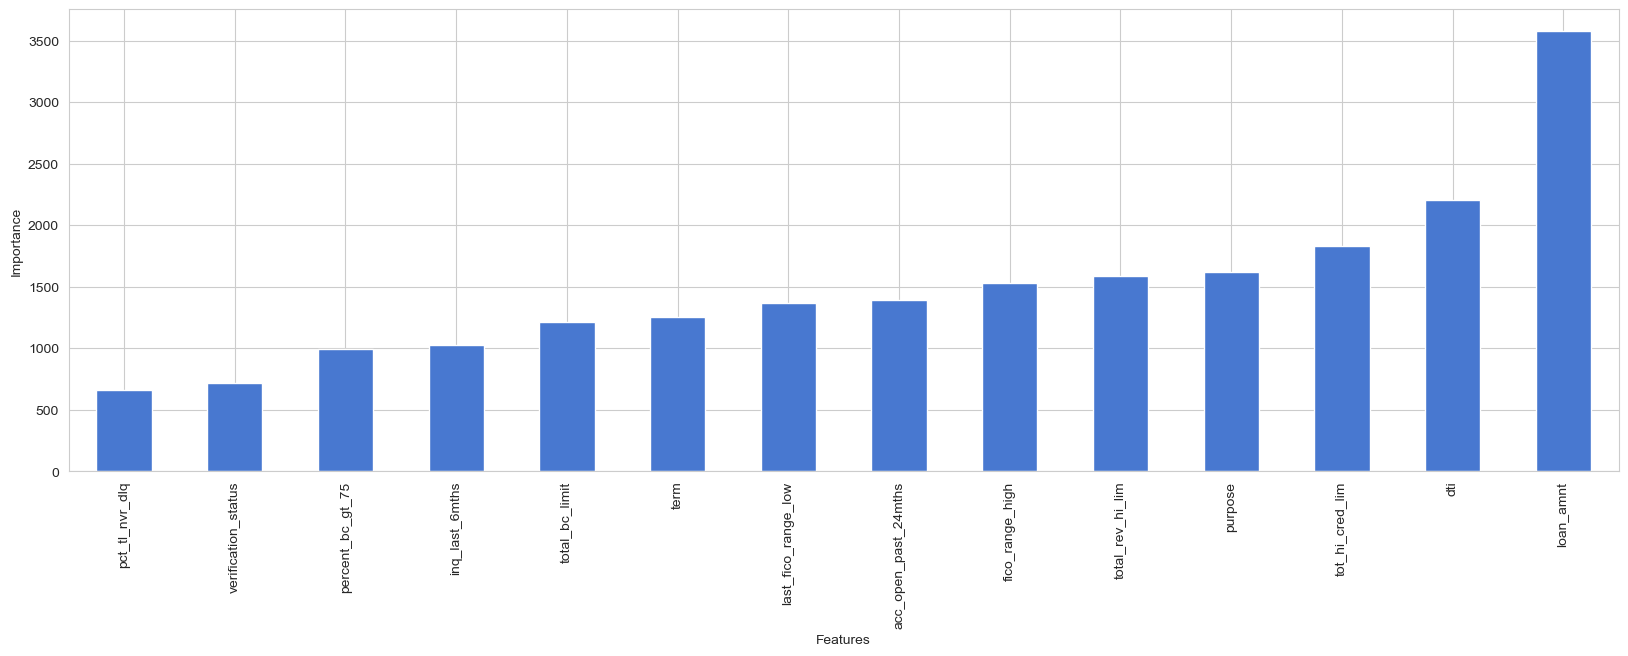

In [67]:
# importance of all features based of initial model

sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

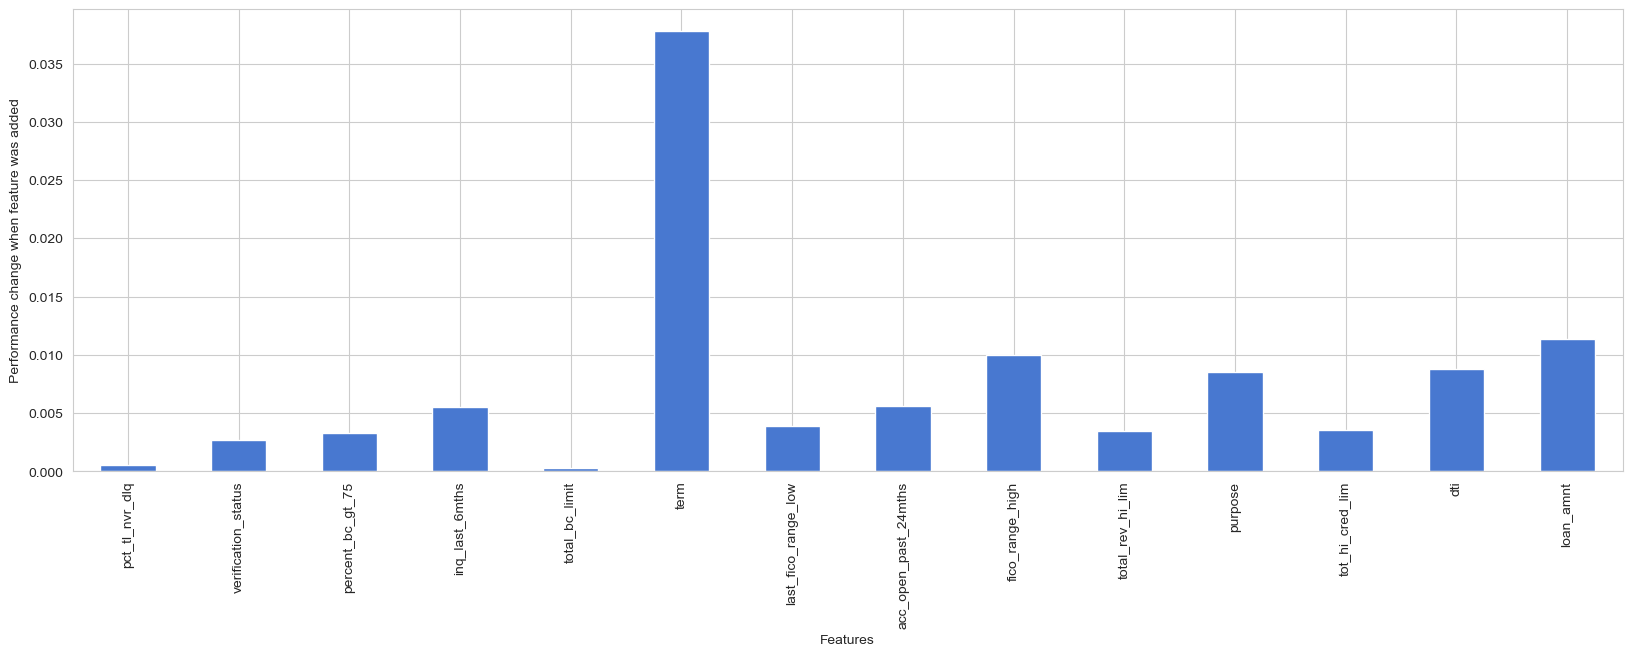

In [68]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [72]:
# Features will be dropped
sel.features_to_drop_

['total_bc_limit', 'verification_status', 'pct_tl_nvr_dlq']

In [73]:
# Select important features
X_train_grade = sel.transform(X_train_grade)
X_val_grade = sel.transform(X_val_grade)
X_test_grade = sel.transform(X_test_grade)

# Fit the model with the selected features for comparison
model.fit(X_train_grade, y_train_grade_encoded)
y_pred_val = model.predict_proba(X_val_grade)
roc_auc_per_class_val = roc_auc_score(y_val_grade_encoded, y_pred_val, 
                                      multi_class='ovr')

print('ROC AUC score before removing features:', sel.initial_model_performance_)
print('ROC AUC score after removing features:', roc_auc_per_class_val)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.501664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 1464560, number of used features: 11
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
ROC AUC score before removing features: 0.8130219091552205
ROC AUC score after removing features: 0.810597544736836


ROC AUC score before removing features: 0.8130219091552205
ROC AUC score after removing features: 0.810597544736836
After removing these columns, our ROC AUC score decreased by 0.0024. 
It looks like these columns do not have an impact on our model prediction. 
And we reduced dimensionality successfully.

## Predicting Loan Grade

In [16]:
# create pipelines for data preprocessor and model selection.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)
# Selecting numeric and categorical features. Assigning them to preprocessor
# pipeline.
numeric_features = [
    "fico_range_high", "last_fico_range_low", "percent_bc_gt_75", 
    "loan_amnt", "total_rev_hi_lim", "inq_last_6mths", "acc_open_past_24mths",
    "dti", "tot_hi_cred_lim"
]

categorical_features = ["term", "purpose"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

In [12]:
def evaluate_classifiers_multi(X_train: pd.DataFrame,
                               y_train_encoded: np.ndarray,
                               X_val: pd.DataFrame,
                               y_val_encoded: np.ndarray,
                               undersampling_strategy: Dict[int, int],
                               oversampling_strategy: Dict[int, int],
                               preprocessor,
                               sample_size: float = 0.3) -> pd.DataFrame:
    """
    Evaluates a list of classifiers for multiclass classification on given 
    datasets and returns a DataFrame containing performance metrics.

    Parameters:
  
    - X_train: DataFrame containing training features.
    - y_train_encoded: Numpy array containing encoded training labels.
    - X_val: DataFrame containing validation features.
    - y_val_encoded: Numpy array containing encoded validation labels.
    - undersampling_strategy: Dictionary containing class labels and desired counts for undersampling.
    - oversampling_strategy: Dictionary containing class labels and desired counts for oversampling.
    - preprocessor: Scikit-learn transformer for preprocessing.
    - sample_size: Proportion of data in % to use for model selection.


    Returns:
    - DataFrame containing classifier names and performance metrics
    """


    # Taking smaller sample for model selection part and validation
    X_select_train, _, y_select_train_encoded, _ = (train_test_split
                                                    (X_train,
                                                     y_train_encoded,
                                                     test_size=1 - sample_size,
                                                     stratify=y_train_encoded))

    num_classes = len(set(y_val_encoded))

    # Multiply the sampling strategies by the sample_size
    undersampling_strategy = {k: int(v * sample_size) for k, v in undersampling_strategy.items()}
    oversampling_strategy = {k: int(v * sample_size) for k, v in oversampling_strategy.items()}

    classifiers = [
        LogisticRegression(n_jobs=-1, class_weight='balanced', solver='saga'),
        RandomForestClassifier(n_jobs=-1,
                               class_weight='balanced',
                               criterion='entropy'),
        DecisionTreeClassifier(class_weight='balanced', criterion='entropy'),
        BaggingClassifier(n_jobs=-1),
        AdaBoostClassifier(algorithm='SAMME'),
        GradientBoostingClassifier(),
        XGBClassifier(eval_metric='auc',
                      n_jobs=-1,
                      objective='multi:softmax',
                      num_class=num_classes),
        LGBMClassifier(n_jobs=-1,
                       class_weight='balanced',
                       objective='multiclass',
                       num_class=num_classes),
        CatBoostClassifier(verbose=False,
                           task_type="CPU",
                           thread_count=-1,
                           loss_function='MultiClass')
    ]

    results = []

    for classifier in classifiers:
        start_time = time.time()

        # Define the pipeline
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("undersample", RandomUnderSampler(sampling_strategy=undersampling_strategy)),
                ("oversample", SMOTE(sampling_strategy=oversampling_strategy)),
                ("classifier", classifier)
            ]
        )

        # Fit and predict
        model = pipeline.fit(X_select_train, y_select_train_encoded)
        predictions = model.predict(X_val)
        probabilities = model.predict_proba(X_val)

        end_time = time.time()

        # Compute metrics
        accuracy = accuracy_score(y_val_encoded, predictions)
        precision = precision_score(y_val_encoded, predictions,
                                    average='weighted',zero_division=0)
        recall = recall_score(y_val_encoded, predictions, average='weighted')
        f1 = f1_score(y_val_encoded, predictions, average='weighted')
        roc_auc = roc_auc_score(y_val_encoded, probabilities,
                                multi_class='ovr', average='weighted')
        time_elapsed = end_time - start_time

        results.append({
            'Classifier': type(classifier).__name__,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'ROC AUC': roc_auc,
            'Time (s)': time_elapsed
        })
        print(type(classifier).__name__ + ' trained successfully in '
              + f"{time_elapsed:.3f}" + ' s')

    results_df = pd.DataFrame(results)
    return results_df


In [242]:
original_counts = Counter(y_train_grade_encoded)

# After testing several strategies, this works the best
undersampling_strategy = {
    1: int(original_counts[1] * 0.3),  # class 'B' 430009
    2: int(original_counts[2] * 0.4),  # class 'C' 423384
    0: int(original_counts[0] * 0.3),  # class 'A' 282117
    3: int(original_counts[3] * 0.7)   # class 'D' 86495
}
oversampling_strategy = {
    4: int(original_counts[4] * 1.5),  # class 'E' 86495
    5: int(original_counts[5] * 4),  # class 'F' 26377
    6: int(original_counts[6] * 10),  # class 'G' 7605
}

# Evaluates a list of classifiers for multiclass classification
results_df = evaluate_classifiers_multi(X_train_grade,
                                        y_train_grade_encoded,
                                        X_val_grade,
                                        y_val_grade_encoded,
                                        undersampling_strategy,
                                        oversampling_strategy,
                                        preprocessor,
                                        sample_size=0.3)
print(results_df)


The max_iter was reached which means the coef_ did not converge


LogisticRegression trained successfully in 64.622 s
RandomForestClassifier trained successfully in 57.398 s
DecisionTreeClassifier trained successfully in 21.090 s
BaggingClassifier trained successfully in 21.539 s
AdaBoostClassifier trained successfully in 28.982 s
GradientBoostingClassifier trained successfully in 905.102 s
XGBClassifier trained successfully in 156.991 s
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5400
[LightGBM] [Info] Number of data points in the train set: 252090, number of used features: 22
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

Classifier  Accuracy  Precision  Recall    F1  ROC AUC  \
0          LogisticRegression     0.389      0.418   0.389 0.394    0.728   
1      RandomForestClassifier     0.431      0.439   0.431 0.434    0.742   
2      DecisionTreeClassifier     0.334      0.364   0.334 0.345    0.580   
3           BaggingClassifier     0.402      0.407   0.402 0.404    0.695   
4          AdaBoostClassifier     0.305      0.293   0.305 0.275    0.621   
5  GradientBoostingClassifier     0.443      0.453   0.443 0.446    0.750   
6               XGBClassifier     0.460      0.465   0.460 0.461    0.767   
7              LGBMClassifier     0.443      0.449   0.443 0.437    0.767   
8          CatBoostClassifier     0.467      0.472   0.467 0.467    0.772   

   Time (s)  
0    64.622  
1    57.398  
2    21.090  
3    21.539  
4    28.982  
5   905.102  
6   156.991  
7    14.178  
8   172.414

The Best performers were CatBoostClassifier and XGBClassifier, as XGBC had 
faster computing times and got almost similar results, I chose XGBC for 
further tuning. 

In [246]:
# Hyperparameter grid for XGBClassifier
param_grid_xgb = {
    'classifier__n_estimators': randint(50, 500),
    'classifier__learning_rate': uniform(0.01, 0.5),
    'classifier__max_depth': randint(3, 10)
}

# Under-sampling
rus = RandomUnderSampler(sampling_strategy=undersampling_strategy)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_grade,
                                                              y_train_grade_encoded)

# Over-sampling
smote = SMOTE(sampling_strategy=oversampling_strategy)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_undersampled,
                                                        y_train_undersampled)


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(eval_metric='auc',
                                     n_jobs=-1,
                                     objective='multi:softmax',
                                     num_class=len(set(y_train_grade)),
                                     early_stopping_rounds=5)
         )
    ]
)

skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=None)

# Hyperparameter tuning using RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_xgb,
    scoring="roc_auc_ovr",
    n_iter=100,
    cv=skf,
    n_jobs=-1,
    random_state=42,
    verbose=2
)
preprocessor.fit(X_train_balanced)
randomized_search.fit(X_train_balanced, y_train_balanced,
                      classifier__eval_set=[(pipeline
                                             .named_steps["preprocessor"].transform(X_val_grade)
                                             , y_val_grade_encoded)])


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[0]	validation_0-auc:0.58392
[1]	validation_0-auc:0.60419
[2]	validation_0-auc:0.60778
[3]	validation_0-auc:0.61454
[4]	validation_0-auc:0.61779
[5]	validation_0-auc:0.62077
[6]	validation_0-auc:0.62428
[7]	validation_0-auc:0.62337
[8]	validation_0-auc:0.62499
[9]	validation_0-auc:0.62490
[10]	validation_0-auc:0.62441
[11]	validation_0-auc:0.62672
[12]	validation_0-auc:0.62779
[13]	validation_0-auc:0.62792
[14]	validation_0-auc:0.62827
[15]	validation_0-auc:0.62768
[16]	validation_0-auc:0.62877
[17]	validation_0-auc:0.63007
[18]	validation_0-auc:0.63122
[19]	validation_0-auc:0.63120
[20]	validation_0-auc:0.63025
[21]	validation_0-auc:0.62984
[22]	validation_0-auc:0.62890


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['fico_range_high',
                                                                                'last_fico_range_low',
                                                                                'percent_bc_gt_75',
                                                                                'loan_amnt',
                                                                                'total_rev_hi_lim',
                                                                                '...
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FD0588DCC0>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD0103C040>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD02302200>},
                   random_state=42, scoring='roc_auc_ovr', verbose=2)

In [247]:
best_estimator = randomized_search.best_estimator_

start_time = time.time()

predictions = best_estimator.predict(X_val_grade)
probabilities = best_estimator.predict_proba(X_val_grade)
roc_auc = roc_auc_score(y_val_grade_encoded, probabilities,
                        multi_class='ovr', average='weighted')
end_time = time.time()

print("XGBClassifier")
print("ROC_AUC:", roc_auc)
print("Time:", end_time - start_time)
print("Best parameters:", randomized_search.best_params_)
print("***")


XGBClassifier
ROC_AUC : 0.7546194164924754
Time:  10510.583668231964
Best parameters: {'classifier__learning_rate': 0.172172510502637, 'classifier__max_depth': 9, 'classifier__n_estimators': 397}
***




***
XGBClassifier
ROC_AUC : 0.7546194164924754
Time:  10510.583668231964
Best parameters: {'classifier__learning_rate': 0.172172510502637, 'classifier__max_depth': 9, 'classifier__n_estimators': 397}
***
After getting best found hyperparameters, we should train our model and test
 it with test sets.


XGBoost Classifier:


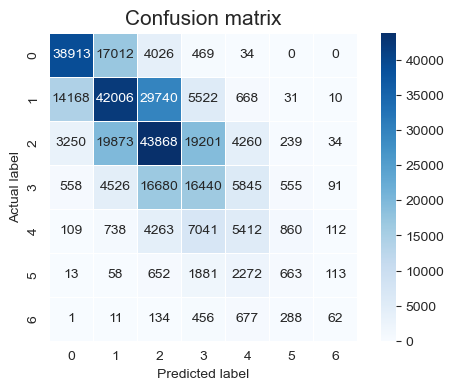


Classification Report:
               precision    recall  f1-score   support

           A       0.68      0.64      0.66     60454
           B       0.50      0.46      0.48     92145
           C       0.44      0.48      0.46     90725
           D       0.32      0.37      0.34     44695
           E       0.28      0.29      0.29     18535
           F       0.25      0.12      0.16      5652
           G       0.15      0.04      0.06      1629

    accuracy                           0.47    313835
   macro avg       0.38      0.34      0.35    313835
weighted avg       0.47      0.47      0.47    313835


In [22]:
original_counts = Counter(y_train_grade_encoded)

undersampling_strategy = {
    1: int(original_counts[1] * 0.3),
    2: int(original_counts[2] * 0.4),
    0: int(original_counts[0] * 0.3),
    3: int(original_counts[3] * 0.7)
}
oversampling_strategy = {
    4: int(original_counts[4] * 1.5),
    5: int(original_counts[5] * 4),
    6: int(original_counts[6] * 10),
}

pipeline_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("undersample", RandomUnderSampler(
            sampling_strategy=undersampling_strategy,
            random_state=42)),
        ("oversample", SMOTE(
            sampling_strategy=oversampling_strategy,
            random_state=42)),
        ("classifier", XGBClassifier(n_estimators=379,
                                     learning_rate=0.172172510502637,
                                     max_depth=9,
                                     eval_metric='auc',
                                     n_jobs=-1,
                                     verbosity=1,
                                     objective='multi:softmax',
                                     num_class=len(set(y_train_grade_encoded)),
                                     early_stopping_rounds=10))
    ]
)

preprocessor.fit(X_train_grade)
xgb_model = pipeline_xgb.fit(X_train_grade,
                             y_train_grade_encoded,
                             classifier__eval_set=[(pipeline_xgb
                            .named_steps["preprocessor"].transform(X_val_grade)
                                                    , y_val_grade_encoded)])

xgb_predictions = xgb_model.predict(X_test_grade)

xgb_predictions_labels = encoder_grade.inverse_transform(xgb_predictions)

print("XGBoost Classifier:")
conf_matrix_pred(y_test_grade, xgb_predictions_labels)
print("\nClassification Report:\n",
      classification_report(y_test_grade, xgb_predictions_labels,
                            zero_division=0))


Early stopping stopped model training with 246 estimators, which prevents 
overfitting. Overall accuracy is 47 %, which is quite low and not a very good 
metric for imbalanced dataset.
Best performing classes and their F1 scores were: A 0.66, B 0.48, C 0.46
Lowest performers : G 0.06, F 0.16 E 0.29
To get better results we need more data for minority classes.

In [28]:
# Save the model to a file
joblib.dump(xgb_model, 'xgb_model_grade.pkl')

# Get the classes from the encoder after encoding the target variable
classes_original_y = encoder_grade.classes_
classes_encoded_y = range(len(encoder_grade.classes_))

# Convert the classes to a dictionary
encoder_mapping_y = {str(encoded): original for encoded, original in zip(classes_encoded_y, classes_original_y)}

# Save the dictionary to a JSON file
with open('encoder_grade.json', 'w') as file:
    json.dump(encoder_mapping_y, file)


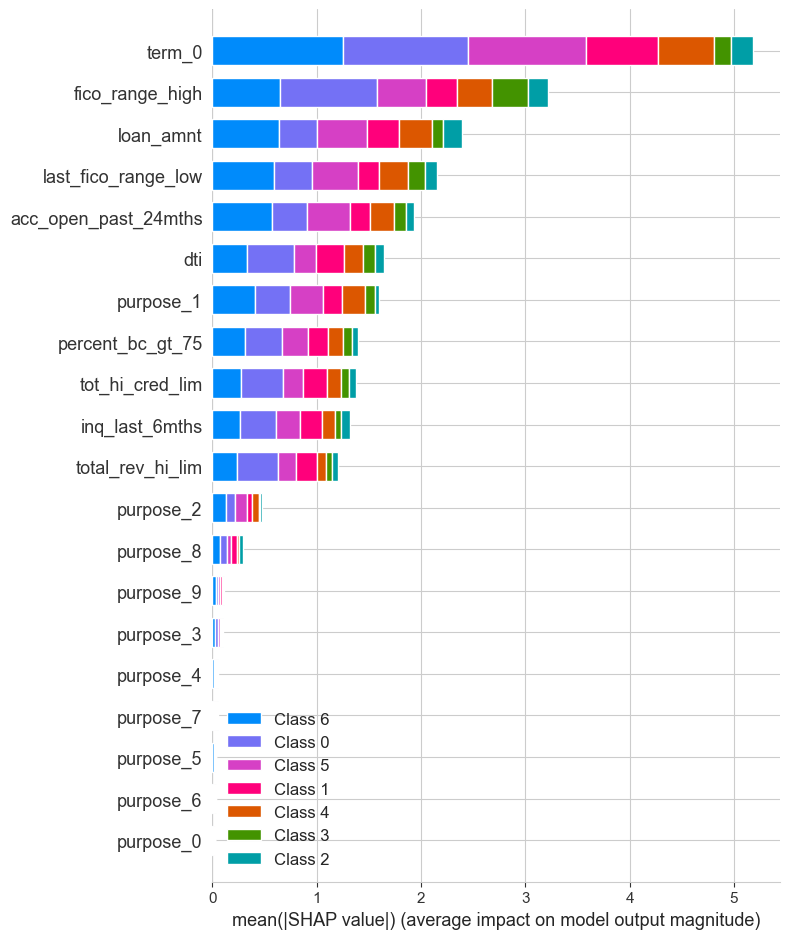

In [23]:
# Get feature names after one-hot encoding
transformed_feature_names = (encoder_grade.get_feature_names_out
                             (input_features=categorical_features))

all_feature_names = numeric_features + list(transformed_feature_names)

explainer = shap.Explainer(xgb_model, feature_perturbation='interventional')
X_train_transformed = xgb_model.named_steps['preprocessor'].transform(X_train_grade)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed[:1000], check_additivity=False)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_transformed[:1000], feature_names=all_feature_names)


## 5. Predicting Loan Sub-Grade

In [10]:
relevant_columns = ['fico_range_high', 'last_fico_range_low', 'term',
                    'percent_bc_gt_75', 'loan_amnt', 'total_rev_hi_lim', 
                    'inq_last_6mths',
                    'acc_open_past_24mths', 'dti', 'purpose', 
                    'tot_hi_cred_lim','grade','sub_grade','int_rate']
accepted_df = pd.read_parquet('accepted_df.parquet')
accepted_df = accepted_df[relevant_columns]
print(accepted_df.shape)
accepted_df.head()

(2092229, 14)


fico_range_high  last_fico_range_low        term  percent_bc_gt_75  \
0          679.000              560.000   36 months             0.000   
1          719.000              695.000   36 months             7.700   
2          699.000              700.000   60 months            50.000   
3          789.000              675.000   60 months             0.000   
4          699.000              700.000   60 months            60.000   

   loan_amnt  total_rev_hi_lim  inq_last_6mths  acc_open_past_24mths    dti  \
0   3600.000          9300.000           1.000                 4.000  5.910   
1  24700.000        111800.000           4.000                 4.000 16.060   
2  20000.000         14000.000           0.000                 6.000 10.780   
3  35000.000         67300.000           0.000                 2.000 17.060   
4  10400.000         34000.000           3.000                10.000 25.370   

              purpose  tot_hi_cred_lim grade sub_grade  int_rate  
0  debt_consolidation       178050.000     C        C4    13.990  
1      small_business       314017.000     C        C1    11.990  
2    home_improvement       218418.000     B        B4    10.780  
3  debt_consolidation       381215.000     C        C5    14.850  
4      major_purchase       439570.000     F        F1    22.450

In [45]:
X = accepted_df.drop(['sub_grade', 'int_rate'], axis=1)
y = accepted_df['sub_grade']

# Splitting dataset to training, validation, and test sets
X_train_subg, X_temp, y_train_subg, y_temp = train_test_split(X, y,
                                                              test_size=0.3,
                                                              stratify=y)
X_val_subg, X_test_subg, y_val_subg, y_test_subg = train_test_split(
                                                                X_temp,
                                                                y_temp,
                                                                test_size=0.5,
                                                                stratify=y_temp
                                                            )

print("X_train_subg shape:", X_train_subg.shape)
print("X_val_subg shape:", X_val_subg.shape)
print("X_test_subg shape:", X_test_subg.shape)


X_train_subg shape: (1464560, 12)
X_val_subg shape: (313834, 12)
X_test_subg shape: (313835, 12)


In [8]:
print("Value counts of sub_grade for X_train_subg grouped by grade:\n")
for grade, group in X_train_subg.groupby('grade'):
    print(f"Grade {grade}:")
    print(y_train_subg[group.index].value_counts())
    print()

Value counts of sub_grade for X_train_subg grouped by grade:
Grade A:
A5    69691
A4    61614
A1    57791
A3    47497
A2    45524
Name: sub_grade, dtype: int64

Grade B:
B5    90439
B4    90358
B3    84321
B2    82608
B1    82283
Name: sub_grade, dtype: int64

Grade C:
C1    94443
C2    84714
C3    84540
C4    83291
C5    76395
Name: sub_grade, dtype: int64

Grade D:
D1    53035
D2    46691
D3    41563
D4    36504
D5    30780
Name: sub_grade, dtype: int64

Grade E:
E1    21381
E2    19021
E3    17074
E5    14523
E4    14496
Name: sub_grade, dtype: int64

Grade F:
F1    8495
F2    5859
F3    4904
F4    3863
F5    3257
Name: sub_grade, dtype: int64

Grade G:
G1    2578
G2    1672
G3    1317
G4    1063
G5     975
Name: sub_grade, dtype: int64


In [5]:
# create pipelines for data preprocessor and model selection.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)
# Selecting numeric and categorical features. Assigning them to preprocessor
# pipeline.
numeric_features = [
    "fico_range_high", "last_fico_range_low", "percent_bc_gt_75",
    "loan_amnt", "total_rev_hi_lim", "inq_last_6mths", "acc_open_past_24mths",
    "dti", "tot_hi_cred_lim"
]

categorical_features = ["term", "purpose", "grade"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

In [21]:
grades = X_train_subg['grade'].unique()
encoder_subg_dict = {}

# For each grade, create a LabelEncoder() and fit it to the dictionary
for grade in grades:
    encoder_subg = LabelEncoder()

    y_grade = y_train_subg[X_train_subg['grade'] == grade]

    encoder_subg.fit(y_grade)
    encoder_subg_dict[grade] = encoder_subg


In [6]:
# Save to a pickle file
with open('encoder_subg_dict.pkl', 'wb') as f:
    pickle.dump(encoder_subg_dict, f)


In [26]:
def evaluate_classifiers_by_grade(X_train_subg: pd.DataFrame,
                                  y_train_subg: pd.Series,
                                  X_val_subg: pd.DataFrame,
                                  y_val_subg: pd.Series,
                                  preprocessor,
                                  encoder_subg_dict: Dict[str, LabelEncoder]) -> pd.DataFrame:
    """
    Evaluate multiple classifiers on training and validation datasets filtered 
    by grades.
    
    Parameters:
    -----------
    X_train_subg : Training feature data with a 'grade' column to be used for 
    grouping.
        
    y_train_subg : Training target labels corresponding to X_train_subg.
        
    X_val_subg : Validation feature data with a 'grade' column.
        
    y_val_subg : Validation target labels corresponding to X_val_subg.
        
    preprocessor : A preprocessing step or pipeline (e.g., scaler, encoder) 
    to be applied before training.
        
    encoder_subg_dict : A dictionary where keys are grades and values are 
    initialized `LabelEncoder` instances specific to each grade's subgrades.

    Returns:
    --------
    results_df : pd.DataFrame
    A DataFrame containing the performance metrics of each classifier for 
    each grade. Metrics include accuracy, precision, recall, F1 score, ROC 
    AUC, and elapsed time.
    """
    grades = X_train_subg['grade'].unique()
    results = []

    # Filter datasets by each grade
    for grade in grades:
        print(f'Training grade: {grade}')
        # Filter training set by the current grade
        X_train_grade = X_train_subg[X_train_subg['grade'] == grade]
        y_train_grade = y_train_subg[X_train_grade.index]

        y_train_grade_encoded = encoder_subg_dict[grade].transform(y_train_grade)
        print(f"Unique classes for grade {grade}: ", np.unique(y_train_grade_encoded))
              
        num_classes = len(set(y_train_grade_encoded))

        classifiers = [
            LogisticRegression(n_jobs=-1, class_weight='balanced', solver='saga'),
            RandomForestClassifier(n_jobs=-1,
                                   class_weight='balanced',
                                   criterion='entropy'),
            DecisionTreeClassifier(class_weight='balanced', criterion='entropy'),
            BaggingClassifier(n_jobs=-1),
            AdaBoostClassifier(algorithm='SAMME'),
            XGBClassifier(eval_metric='auc',
                          n_jobs=-1,
                          objective='multi:softmax',
                          num_class=num_classes),
            LGBMClassifier(n_jobs=-1,
                           class_weight='balanced',
                           objective='multiclass',
                           num_class=num_classes),
            CatBoostClassifier(verbose=False,
                               task_type="CPU",
                               thread_count=-1,
                               loss_function='MultiClass')
        ]
        for classifier in classifiers:
            start_time = time.time()
            # Define the pipeline
            pipeline = Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("classifier", classifier)
                ]
            )

            # Filter validation set by the current grade
            X_val_grade = X_val_subg[X_val_subg['grade'] == grade]
            y_val_grade = y_val_subg[X_val_grade.index]
            
            y_val_grade_encoded = (encoder_subg_dict[grade]
                                   .transform(y_val_grade))

            # Fit and predict
            model = pipeline.fit(X_train_grade, y_train_grade_encoded)
            predictions = model.predict(X_val_grade)
            probabilities = model.predict_proba(X_val_grade)
            end_time = time.time()

            # Compute metrics
            accuracy = accuracy_score(y_val_grade_encoded, predictions)
            precision = precision_score(y_val_grade_encoded, 
                                        predictions, 
                                        average='weighted', 
                                        zero_division=0)
            recall = recall_score(y_val_grade_encoded, 
                                  predictions, 
                                  average='weighted')
            f1 = f1_score(y_val_grade_encoded, predictions, average='weighted')
            roc_auc = roc_auc_score(y_val_grade_encoded, 
                                    probabilities, 
                                    multi_class='ovr', 
                                    average='weighted')
            time_elapsed = end_time - start_time

            results.append({
                'Grade': grade,
                'Classifier': type(classifier).__name__,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'ROC AUC': roc_auc,
                'Time (s)': time_elapsed
            })
            print(type(classifier).__name__ + ' trained successfully in ' + f"{time_elapsed:.3f}" + ' s')

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Run function, to get results of all classifiers
results_df = evaluate_classifiers_by_grade(X_train_subg,
                                           y_train_subg,
                                           X_val_subg,
                                           y_val_subg,
                                           preprocessor,
                                           encoder_subg_dict)


In [30]:
results_df

Grade              Classifier  Accuracy  Precision  Recall    F1  ROC AUC  \
0      B      LogisticRegression     0.267      0.247   0.267 0.225    0.584   
1      B  RandomForestClassifier     0.256      0.250   0.256 0.251    0.572   
2      B  DecisionTreeClassifier     0.220      0.219   0.220 0.219    0.512   
3      B       BaggingClassifier     0.237      0.237   0.237 0.235    0.543   
4      B      AdaBoostClassifier     0.250      0.239   0.250 0.237    0.572   
5      B           XGBClassifier     0.278      0.262   0.278 0.257    0.598   
6      B          LGBMClassifier     0.282      0.268   0.282 0.260    0.601   
7      B      CatBoostClassifier     0.281      0.265   0.281 0.260    0.600   
8      C      LogisticRegression     0.249      0.236   0.249 0.223    0.566   
9      C  RandomForestClassifier     0.241      0.234   0.241 0.232    0.549   
10     C  DecisionTreeClassifier     0.213      0.213   0.213 0.213    0.508   
11     C       BaggingClassifier     0.225      0.220   0.225 0.218    0.526   
12     C      AdaBoostClassifier     0.251      0.234   0.251 0.199    0.562   
13     C           XGBClassifier     0.262      0.247   0.262 0.231    0.574   
14     C          LGBMClassifier     0.258      0.246   0.258 0.235    0.576   
15     C      CatBoostClassifier     0.263      0.247   0.263 0.231    0.575   
16     F      LogisticRegression     0.247      0.259   0.247 0.231    0.535   
17     F  RandomForestClassifier     0.300      0.237   0.300 0.225    0.528   
18     F  DecisionTreeClassifier     0.228      0.230   0.228 0.229    0.504   
19     F       BaggingClassifier     0.260      0.221   0.260 0.227    0.506   
20     F      AdaBoostClassifier     0.322      0.104   0.322 0.157    0.526   
21     F           XGBClassifier     0.296      0.239   0.296 0.227    0.533   
22     F          LGBMClassifier     0.235      0.256   0.235 0.241    0.534   
23     F      CatBoostClassifier     0.306      0.254   0.306 0.236    0.537   
24     D      LogisticRegression     0.234      0.234   0.234 0.207    0.548   
25     D  RandomForestClassifier     0.239      0.226   0.239 0.220    0.528   
26     D  DecisionTreeClassifier     0.212      0.213   0.212 0.213    0.504   
27     D       BaggingClassifier     0.226      0.215   0.226 0.214    0.510   
28     D      AdaBoostClassifier     0.257      0.228   0.257 0.144    0.546   
29     D           XGBClassifier     0.256      0.233   0.256 0.207    0.548   
30     D          LGBMClassifier     0.238      0.236   0.238 0.228    0.551   
31     D      CatBoostClassifier     0.257      0.236   0.257 0.212    0.551   
32     A      LogisticRegression     0.331      0.319   0.331 0.304    0.651   
33     A  RandomForestClassifier     0.336      0.307   0.336 0.309    0.648   
34     A  DecisionTreeClassifier     0.260      0.261   0.260 0.260    0.535   
35     A       BaggingClassifier     0.297      0.288   0.297 0.290    0.605   
36     A      AdaBoostClassifier     0.325      0.244   0.325 0.250    0.634   
37     A           XGBClassifier     0.352      0.313   0.352 0.303    0.669   
38     A          LGBMClassifier     0.343      0.332   0.343 0.329    0.669   
39     A      CatBoostClassifier     0.355      0.319   0.355 0.307    0.671   
40     G      LogisticRegression     0.250      0.266   0.250 0.251    0.556   
41     G  RandomForestClassifier     0.316      0.260   0.316 0.244    0.536   
42     G  DecisionTreeClassifier     0.235      0.235   0.235 0.235    0.506   
43     G       BaggingClassifier     0.282      0.243   0.282 0.249    0.506   
44     G      AdaBoostClassifier     0.339      0.190   0.339 0.187    0.550   
45     G           XGBClassifier     0.301      0.253   0.301 0.260    0.535   
46     G          LGBMClassifier     0.245      0.265   0.245 0.252    0.539   
47     G      CatBoostClassifier     0.286      0.237   0.286 0.244    0.534   
48     E      LogisticRegression     0.238      0.244   0.238 0.203    0.562   
49 

To generalize results, we should group our dataframe by classifier and 
compare it

In [31]:
results_df.groupby('Classifier').mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


Accuracy  Precision  Recall    F1  ROC AUC  Time (s)
Classifier                                                                  
AdaBoostClassifier         0.285      0.210   0.285 0.191    0.563    20.505
BaggingClassifier          0.252      0.236   0.252 0.237    0.532    15.045
CatBoostClassifier         0.286      0.257   0.286 0.246    0.575    89.606
DecisionTreeClassifier     0.226      0.227   0.226 0.227    0.511    10.189
LGBMClassifier             0.264      0.264   0.264 0.254    0.576     6.304
LogisticRegression         0.259      0.258   0.259 0.235    0.572    24.177
RandomForestClassifier     0.276      0.250   0.276 0.244    0.558    37.804
XGBClassifier              0.285      0.255   0.285 0.245    0.574    91.988

Best performer was LGBMC with 0.576 ROC AUC score and 0.254 F1 score. 
Next step hyperparameter tuning

In [35]:
# noinspection GrazieInspection
def train_best_models_per_grade(X_train: pd.DataFrame,
                                y_train: pd.Series,
                                preprocessor,
                                encoder_subg_dict: Dict[str, LabelEncoder],
                                n_splits: int = 3,
                                n_iter: int = 100,
                                verbose: int = 1) -> Dict[str, Any]:
    """
    Train and tune a LightGBM classifier for each unique grade present in the 
    training data.
    
    Parameters:
    -----------
    X_train : Training feature data with a 'grade' column to be used for grouping.
        
    y_train : Training target labels corresponding to X_train.
        
    preprocessor : A preprocessing step or pipeline (e.g., scaler, encoder) 
    to be applied before training.
        
    encoder_subg_dict : A dictionary where keys are grades and values are 
    initialized `LabelEncoder` instances specific to each grade's subgrades.
        
    n_splits : Number of splits for StratifiedKFold cross-validation.
        
    n_iter : Number of iterations for RandomizedSearchCV.
        
    verbose : Controls verbosity of RandomizedSearchCV:
     -1=no messages, 0=silent, 1=messages, 2=detailed messages.

    Returns:
    --------
    best_models : Dict[str, Any]
        A dictionary with grades as keys and the best trained LGBM models 
        (after hyperparameter tuning) as values.
        
    """
    num_classes = len(set(y_train))
    
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ('classifier', LGBMClassifier(class_weight='balanced',
                                          objective='multiclass',
                                          num_class=num_classes))
        ]
    )

    param_grid_lgbmc = {
        'classifier__n_estimators': randint(50, 500),
        'classifier__learning_rate': uniform(0.01, 0.5),
        'classifier__max_depth': randint(3, 10),
        'classifier__num_leaves': randint(20, 100),
        'classifier__subsample': uniform(0.5, 0.5),
        'classifier__boosting_type': ['gbdt', 'dart', 'goss']
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=None)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_lgbmc,
        scoring="roc_auc_ovr",
        n_iter=n_iter,
        cv=skf,
        n_jobs=-1,
        random_state=42,
        verbose=verbose
    )

    best_models = {}
    grades = X_train['grade'].unique()

    for grade in grades:
        print(f'Tuning for grade: {grade}')

        X_train_grade = X_train[X_train['grade'] == grade]
        y_train_grade = y_train[X_train_grade.index]

        # Use the grade-specific encoder to transform the training labels
        y_train_grade_encoded = encoder_subg_dict[grade].transform(y_train_grade)

        random_search.fit(X_train_grade, y_train_grade_encoded)
        best_params = random_search.best_params_
        best_score = random_search.best_score_
        best_model = random_search.best_estimator_

        best_models[grade] = best_model

        print(f'Best ROC AUC score for grade {grade}: {best_score:.3f}')
        print(f'Best parameters for grade {grade}: {best_params}\n')

    return best_models


In [ ]:
best_models_dict = train_best_models_per_grade(X_train_subg, 
                                               y_train_subg, 
                                               preprocessor,
                                               encoder_subg_dict,
                                               n_splits=2,
                                               n_iter=150,
                                               verbose=-1)


In [38]:
# Save the model to a file
joblib.dump(best_models_dict, 'best_models_subg.pkl')


['best_models_subg.pkl']

In [39]:
# Hyperparameters list
desired_params = ['n_estimators', 'learning_rate', 'max_depth', 'num_leaves', 
                  'subsample', 'boosting_type']

hyperparam_list = []

# Iterate over the best_models_dict to get the hyperparameters of each model
for grade, model in best_models_dict.items():
    params = model.named_steps['classifier'].get_params()

    filtered_params = {param: params[param] for param in desired_params}
    filtered_params['grade'] = grade

    hyperparam_list.append(filtered_params)

df_hyperparams = pd.DataFrame(hyperparam_list)

# Set the grade as the index for better readability
df_hyperparams.set_index('grade', inplace=True)

df_hyperparams


n_estimators  learning_rate  max_depth  num_leaves  subsample  \
grade                                                                  
B               387          0.185          4          49      0.777   
C               371          0.024          4          51      0.789   
F               286          0.057          3          20      0.977   
D               350          0.074          4          46      0.520   
A               387          0.185          4          49      0.777   
G               112          0.174          4          81      0.643   
E               286          0.057          3          20      0.977   

      boosting_type  
grade                
B              dart  
C              goss  
F              dart  
D              dart  
A              dart  
G              dart  
E              dart

In this table, we can see that n_estimators were mostly above 280, except 
for the G grade where it was 112. The learning rate varied from 0.057 to 0.185. 
The max_depth parameter was between 3 and 4. The number of leaves varied from 
20 to 51. The most common boosting type was 'dart.' I also experimented with 
both undersampling and oversampling techniques, using various sampling 
strategies. However, I didn't observe any significant improvements in the 
results. Therefore, I decided to keep it simple and remove any sampling.

Grade: D

Classification Report:
               precision    recall  f1-score   support

          D1       0.27      0.83      0.41     11365
          D2       0.26      0.13      0.17     10005
          D3       0.27      0.04      0.06      8907
          D4       0.25      0.07      0.11      7823
          D5       0.28      0.08      0.13      6596

    accuracy                           0.27     44696
   macro avg       0.27      0.23      0.18     44696
weighted avg       0.27      0.27      0.19     44696

---------------------------------------------------------
Grade: B

Classification Report:
               precision    recall  f1-score   support

          B1       0.30      0.50      0.38     17632
          B2       0.27      0.16      0.20     17702
          B3       0.25      0.09      0.13     18069
          B4       0.27      0.23      0.25     19363
          B5       0.31      0.47      0.38     19380

    accuracy                           0.29     92146
   ma

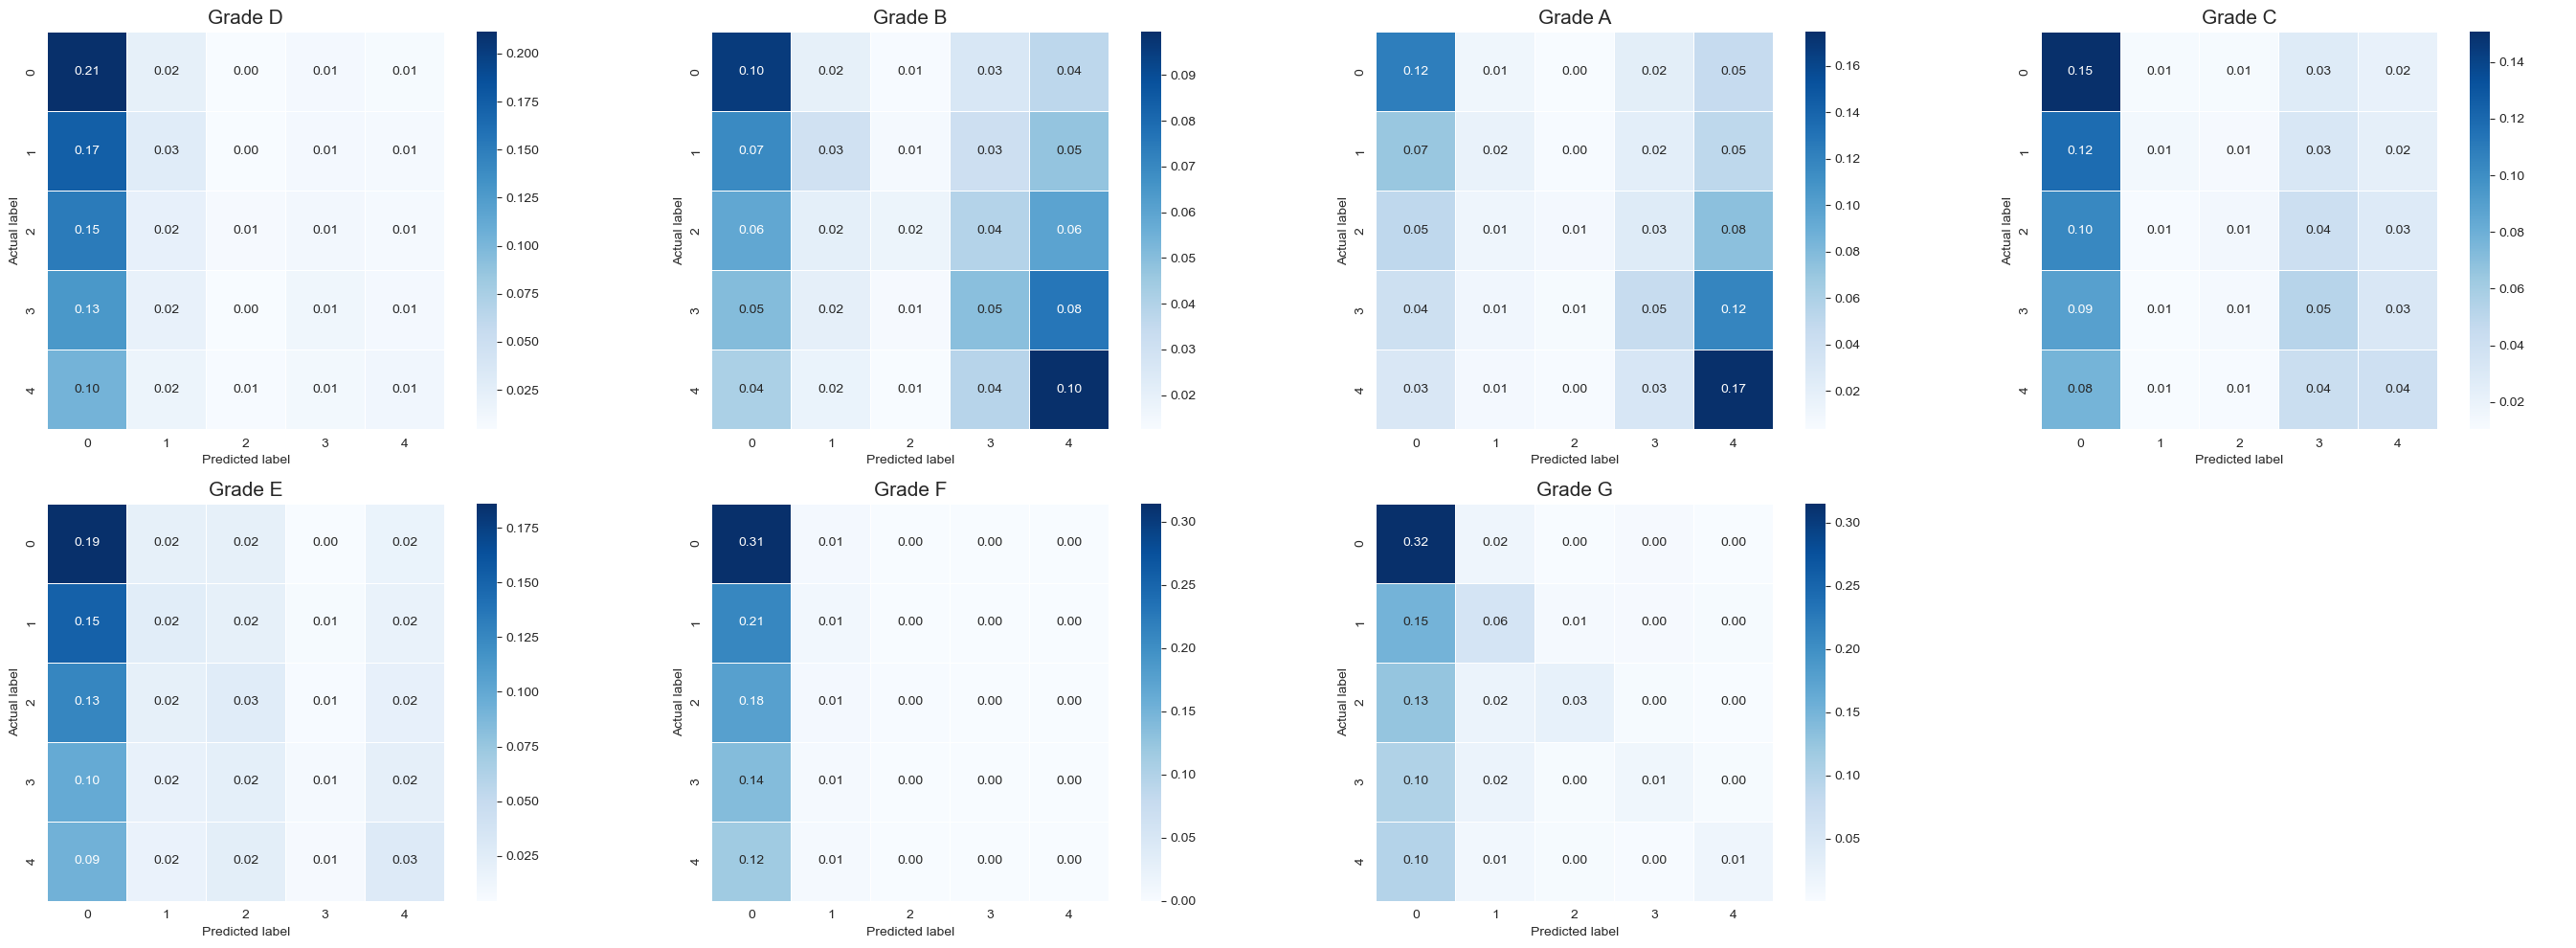

In [13]:
grades = X_train_subg['grade'].unique()

fig, axes = plt.subplots(2, 4, figsize=(28, 10))

# Flatten the 2x4 axes array for easy indexing
axes = axes.ravel()

for idx, grade in enumerate(grades):
    X_test_subg_grade = X_test_subg[X_test_subg['grade'] == grade]
    y_test_subg_grade = y_test_subg[X_test_subg_grade.index]

    grade_predictions = best_models_dict[grade].predict(X_test_subg_grade)

    # Decode the predictions
    decoded_predictions = encoder_subg_dict[grade].inverse_transform(grade_predictions)

    # Generate confusion matrix for the current grade
    cm = confusion_matrix(y_test_subg_grade, decoded_predictions)
    cm_normalized = cm.astype('float') / cm.sum()  # Normalize by total number of instances

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cmap="Blues",
        square=True,
        ax=axes[idx]  # Set the axis to the current subplot
    )
    axes[idx].set_ylabel("Actual label")
    axes[idx].set_xlabel("Predicted label")
    axes[idx].set_title(f"Grade {grade}", size=15)

    print(f"Grade: {grade}")
    print("\nClassification Report:\n", classification_report(y_test_subg_grade,
                                                              decoded_predictions,
                                                              zero_division=0))
    print("---------------------------------------------------------")

# Hide the last (8th) unused subplot
axes[-1].axis('off')

# Display all confusion matrices side by side
plt.tight_layout()
plt.show()


**A & B models**: 
These models performed best in predicting the 1st and 5th subgrades, achieving 
recall values ranging from 0.47 to 0.71. However, other subgrades were predicted 
poorly. The accuracy for grade A is 0.37, and for grade B, it's 0.29. This 
indicates that the model is struggling with effective prediction.

**C, D, E, F, & G models**: 
These models mainly predicted the first subgrade. The recall for the 1st 
subgrade ranges from 0.68 to 0.98. The accuracies of these models vary 
from 0.27 to 0.47.

In conclusion, the models are a little bit disappointing. They are primarily 
predicting just one or two subgrades. To enhance the models, we should gather 
more data, especially for the minority classes. Additionally, exploring or 
engineering new features might help in more efficient subgrade recognition.


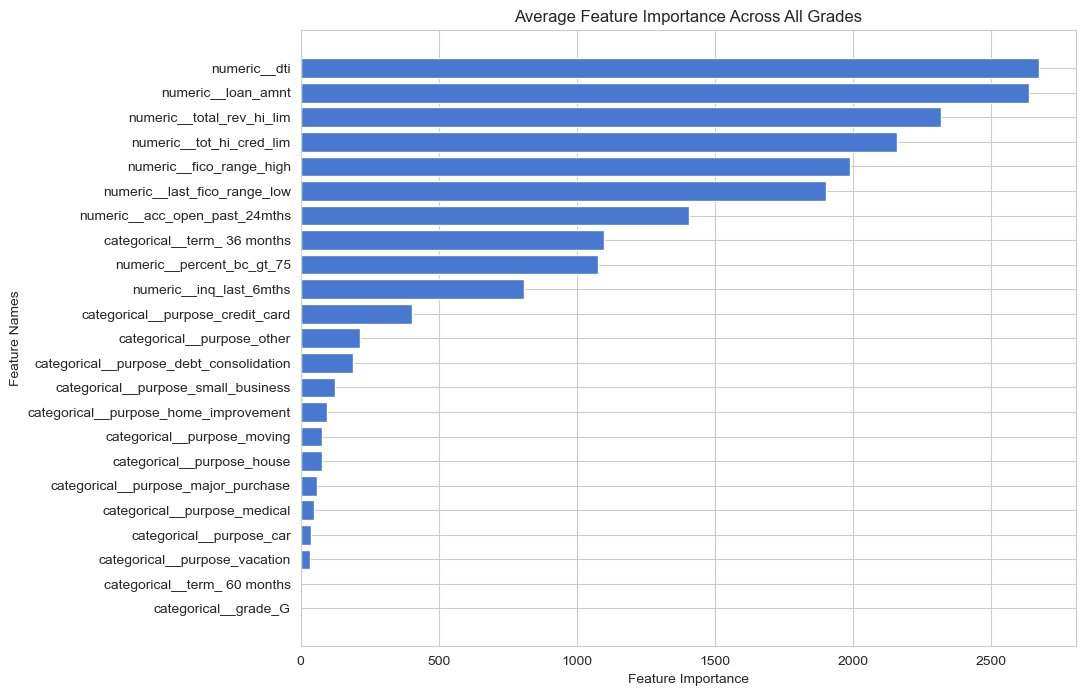

In [21]:
# Initialize a zero array for summing feature importances
sum_importance = np.zeros_like(best_models_dict[grades[0]]
                               .named_steps['classifier'].feature_importances_)

# Sum feature importances from each grade model
for grade in grades:
    model = best_models_dict[grade]
    importance = model.named_steps['classifier'].feature_importances_
    sum_importance += importance

# Calculate average importance
avg_importance = sum_importance / len(grades)

transformed_feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Sort the feature importances for plotting
sorted_idx = np.argsort(avg_importance)

plt.figure(figsize=(10, 8))
plt.barh(transformed_feature_names[sorted_idx], avg_importance[sorted_idx])
plt.title("Average Feature Importance Across All Grades")
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()


**Most Important Features:**
- numeric_dti: It stands out as the most influential feature, followed 
closely by numeric_loan_amnt and numeric_total_rev_hi_lim.
- Other top features include numeric_tot_hi_cred_lim, numeric_fico_range_high, 
and numeric_last_fico_range_low.

**Least Important Features:**
- categorical_term_ 60 months holds minimal importance.
- Other features like categorical_purpose_vacation, categorical_purpose_car, 
and categorical_purpose_medical have relatively lower importance compared to 
the top features.

These feature importances don't indicate whether they decrease or increase 
the predicted values.


## 6. Predicting Interest Rate

In [2]:
relevant_columns = ['fico_range_high', 'last_fico_range_low', 'term',
                    'percent_bc_gt_75', 'loan_amnt', 'total_rev_hi_lim',
                    'inq_last_6mths',
                    'acc_open_past_24mths', 'dti', 'purpose',
                    'tot_hi_cred_lim','grade','sub_grade','int_rate']

accepted_df = pd.read_parquet('accepted_df.parquet')
accepted_df = accepted_df[relevant_columns]
print(accepted_df.shape)
accepted_df.head()

(2092229, 14)


fico_range_high  last_fico_range_low        term  percent_bc_gt_75  \
0          679.000              560.000   36 months             0.000   
1          719.000              695.000   36 months             7.700   
2          699.000              700.000   60 months            50.000   
3          789.000              675.000   60 months             0.000   
4          699.000              700.000   60 months            60.000   

   loan_amnt  total_rev_hi_lim  inq_last_6mths  acc_open_past_24mths    dti  \
0   3600.000          9300.000           1.000                 4.000  5.910   
1  24700.000        111800.000           4.000                 4.000 16.060   
2  20000.000         14000.000           0.000                 6.000 10.780   
3  35000.000         67300.000           0.000                 2.000 17.060   
4  10400.000         34000.000           3.000                10.000 25.370   

              purpose  tot_hi_cred_lim grade sub_grade  int_rate  
0  debt_consolidation       178050.000     C        C4    13.990  
1      small_business       314017.000     C        C1    11.990  
2    home_improvement       218418.000     B        B4    10.780  
3  debt_consolidation       381215.000     C        C5    14.850  
4      major_purchase       439570.000     F        F1    22.450

In [3]:
X = accepted_df.drop(['int_rate'], axis=1)
y = accepted_df['int_rate']

# Splitting dataset to training, validation, and test sets
X_train_int, X_temp, y_train_int, y_temp = train_test_split(X, y,
                                                              test_size=0.3)
X_val_int, X_test_int, y_val_int, y_test_int = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5
)

print("X_train_int shape:", X_train_int.shape)
print("X_val_int shape:", X_val_int.shape)
print("X_test_int shape:", X_test_int.shape)

X_train_int shape: (1464560, 13)
X_val_int shape: (313834, 13)
X_test_int shape: (313835, 13)


In [4]:
# create pipelines for data preprocessor and model selection.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder())
    ]
)
# Selecting numeric and categorical features. Assigning them to preprocessor
# pipeline.
numeric_features_int = [
    "fico_range_high", "last_fico_range_low", "percent_bc_gt_75",
    "loan_amnt", "total_rev_hi_lim", "inq_last_6mths", "acc_open_past_24mths",
    "dti", "tot_hi_cred_lim"
]

categorical_features_int = ["term", "purpose", "grade", "sub_grade"]

preprocessor_int = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features_int),
        ("categorical", categorical_transformer, categorical_features_int)
    ]
)

In [12]:
def evaluate_regressors(X_train: pd.DataFrame,
                        y_train: np.ndarray,
                        X_val: pd.DataFrame,
                        y_val: np.ndarray,
                        preprocessor,
                        sample_size: float = 0.3) -> pd.DataFrame:
    """
    Evaluates a list of regressors on given datasets and returns a DataFrame 
    containing performance metrics.

    Parameters:
    - X_train: DataFrame containing training features.
    - y_train: Numpy array containing training target.
    - X_val: DataFrame containing validation features.
    - y_val: Numpy array containing validation target.
    - preprocessor: Scikit-learn transformer for preprocessing.
    - sample_size: Proportion of data in % to use for model selection.

    Returns:
    - DataFrame containing regressor names and performance metrics
    """

    # Taking a smaller sample for model selection part and validation
    X_select_train, _, y_select_train, _ = train_test_split(X_train, y_train,
                                                        train_size=sample_size,
                                                        random_state=42)

    regressors = [
        LinearRegression(),
        Ridge(),
        Lasso(),
        ElasticNet(),
        # RandomForestRegressor(n_jobs=-1), # took 11302seconds
        GradientBoostingRegressor(),
        XGBRegressor(n_jobs=-1, objective='reg:squarederror',
                     tree_method='gpu_hist', gpu_id=0),
        LGBMRegressor(n_jobs=-1),
        CatBoostRegressor(verbose=False, 
                          task_type="GPU",
                          thread_count=-1)
    ]

    results = []

    for regressor in regressors:
        start_time = time.time()

        # Define the pipeline
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("regressor", regressor)
            ]
        )

        # Fit and predict
        model = pipeline.fit(X_select_train, y_select_train)
        predictions = model.predict(X_val)

        end_time = time.time()

        # Compute metrics
        mae = mean_absolute_error(y_val, predictions)
        mse = mean_squared_error(y_val, predictions)
        r2 = r2_score(y_val, predictions)
        time_elapsed = end_time - start_time

        results.append({
            'Regressor': type(regressor).__name__,
            'MAE': mae,
            'MSE': mse,
            'R-squared': r2,
            'Time (s)': time_elapsed
        })
        print(type(regressor).__name__ + ' trained successfully in ' 
              + f"{time_elapsed:.3f}" + ' s')

    results_df = pd.DataFrame(results)
    return results_df

In [13]:
models_regression = evaluate_regressors(X_train_int,
                                        y_train_int,
                                        X_val_int, 
                                        y_val_int,
                                        preprocessor_int,
                                        sample_size=0.3)

LinearRegression trained successfully in 11.233 s
Ridge trained successfully in 9.636 s
Lasso trained successfully in 5.754 s
ElasticNet trained successfully in 2.852 s
GradientBoostingRegressor trained successfully in 155.219 s
XGBRegressor trained successfully in 5.068 s
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1419
[LightGBM] [Info] Number of data points in the train set: 439368, number of used features: 64
[LightGBM] [Info] Start training from score 13.068315
LGBMRegressor trained successfully in 4.291 s
CatBoostRegressor trained successfully in 22.475 s


In [14]:
models_regression

Regressor   MAE    MSE  R-squared  Time (s)
0           LinearRegression 0.677  0.928      0.961    11.233
1                      Ridge 0.677  0.928      0.961     9.636
2                      Lasso 3.538 20.495      0.129     5.754
3                 ElasticNet 3.165 16.916      0.281     2.852
4  GradientBoostingRegressor 0.688  0.950      0.960   155.219
5               XGBRegressor 0.635  0.839      0.964     5.068
6              LGBMRegressor 0.643  0.844      0.964     4.291
7          CatBoostRegressor 0.635  0.829      0.965    22.475

In the table above, we can observe that the best models with the lowest MAE and 
MSE and the highest R^2 score were XGBRegressor, LGBMRegressor and 
CatBoostRegressor. For further training, I will choose XGBRegressor. It 
offers competitive performance to CatBoostRegressor and LGBMRegressor but 
trains faster and provides a little bit better results than LGBMR.

In [6]:
def xgb_hyperparam_tuning(X_train: pd.DataFrame,
                          y_train: pd.Series,
                          X_val: pd.DataFrame,
                          y_val: pd.Series,
                          preprocessor,
                          sample_size=0.3,
                          early_stop_rounds=5,
                          n_splits: int = 3,
                          n_iter: int = 100,
                          verbose: int = 1) -> Any:
    """
    Train and tune an XGBoost regressor on the given training data using 
    RandomizedSearchCV for hyperparameter optimization.
    
    Parameters:
    -----------
    X_train : Training feature data.
        
    y_train : Training target values corresponding to X_train.
        
    X_val : Validation feature data.
        
    y_val : Validation target values corresponding to X_val.

    preprocessor : A preprocessing step or pipeline to be applied before training.
        
    sample_size : float, default=0.3
        Proportion of training data to use for hyperparameter tuning.
        
    early_stop_rounds : int, default=5
        Number of rounds without improvement to stop training.
        
    n_splits : int, default=3
        Number of splits for KFold cross-validation.
        
    n_iter : int, default=100
        Number of iterations for RandomizedSearchCV.
        
    verbose : int, default=1
        Controls verbosity of RandomizedSearchCV:
        -1=no messages, 0=silent, 1=messages, 2=detailed messages.

    Returns:
    --------
    best_params : The best hyperparameters found during the tuning process.
    """

    # Taking a smaller sample for model selection part and validation
    X_select_train, _, y_select_train, _ = train_test_split(X_train, y_train,
                                                            train_size=sample_size,
                                                            random_state=42)

    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ('regressor', XGBRegressor(objective='reg:squarederror',
                                       tree_method='gpu_hist', 
                                       gpu_id=0,
                                       early_stopping_rounds=early_stop_rounds,
                                       n_jobs=-1))
        ]
    )

    param_grid_xgb = {
        'regressor__n_estimators': randint(50, 500),
        'regressor__learning_rate': uniform(0.01, 0.3),
        'regressor__max_depth': randint(3, 10),
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_xgb,
        scoring="neg_mean_absolute_error",
        n_iter=n_iter,
        cv=kf,
        n_jobs=-1,
        random_state=42,
        verbose=verbose
    )

    preprocessor.fit(X_train)

    random_search.fit(X_train, y_train,
                      regressor__eval_set=[(pipeline
                      .named_steps['preprocessor'].transform(X_val), y_val)]
                      )


    best_params = random_search.best_params_

    print(f'Best MAE score: {-random_search.best_score_:.3f}')
    print(f'Best parameters: {best_params}\n')

    return best_params

In [ ]:
%%time
best_hyperparameters_for_int = xgb_hyperparam_tuning(
    X_train=X_train_int,
    y_train=y_train_int,
    X_val=X_val_int,
    y_val=y_val_int,
    preprocessor=preprocessor_int,
    sample_size=0.4,
    early_stop_rounds=5,
    n_splits=3,
    n_iter=100,
    verbose=2
)


In [8]:
print(best_hyperparameters_for_int)

{'regressor__learning_rate': 0.06990213464750791, 'regressor__max_depth': 9, 'regressor__n_estimators': 293}


In [ ]:
xgbr_int_rate_best = Pipeline(steps=[
    ("preprocessor", preprocessor_int),
    ('regressor', XGBRegressor(objective='reg:squarederror',
                               tree_method='gpu_hist',
                               gpu_id=0,
                               learning_rate=0.0699,
                               max_depth=9,
                               n_estimators=400, #increased as reach max val 
                               early_stopping_rounds=10))
])

# Fit the model
xgbr_int_rate_best.fit(X_train_int, 
                       y_train_int, 
                       regressor__eval_set=[(preprocessor_int.transform(X_val_int), 
                                             y_val_int)])

# Make predictions
predictions_int = xgbr_int_rate_best.predict(X_test_int)

print(f"MAE: {mean_absolute_error(y_test_int, predictions_int)}")
print(f"MSE: {mean_squared_error(y_test_int, predictions_int)}")
print(f"R-squared: {r2_score(y_test_int, predictions_int)}")


-----------
MAE: 0.6238665011540547
MSE: 0.8086983566260502
R-squared: 0.9654798406318338

-----------

After hyperparameter tuning, our MAE decreased from 0.635 to 0.624, and our
MSE decreased from 0.839 to 0.809. This suggests improved prediction accuracy.
The R-squared value rose from 0.964 to 0.965, giving a slight boost in the 
explained variance by the model. The small gap between MAE and MSE indicates 
some large prediction errors. Considering the IQR of int_rate values spans 
from 9.4 to 16, an MAE of 0.624 is notably small, we can assume our model is
 efficient.


In [18]:
# Save the model to a file
joblib.dump(xgbr_int_rate_best, 'xgbr_int_rate_best.pkl')

['xgbr_int_rate_best.pkl']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


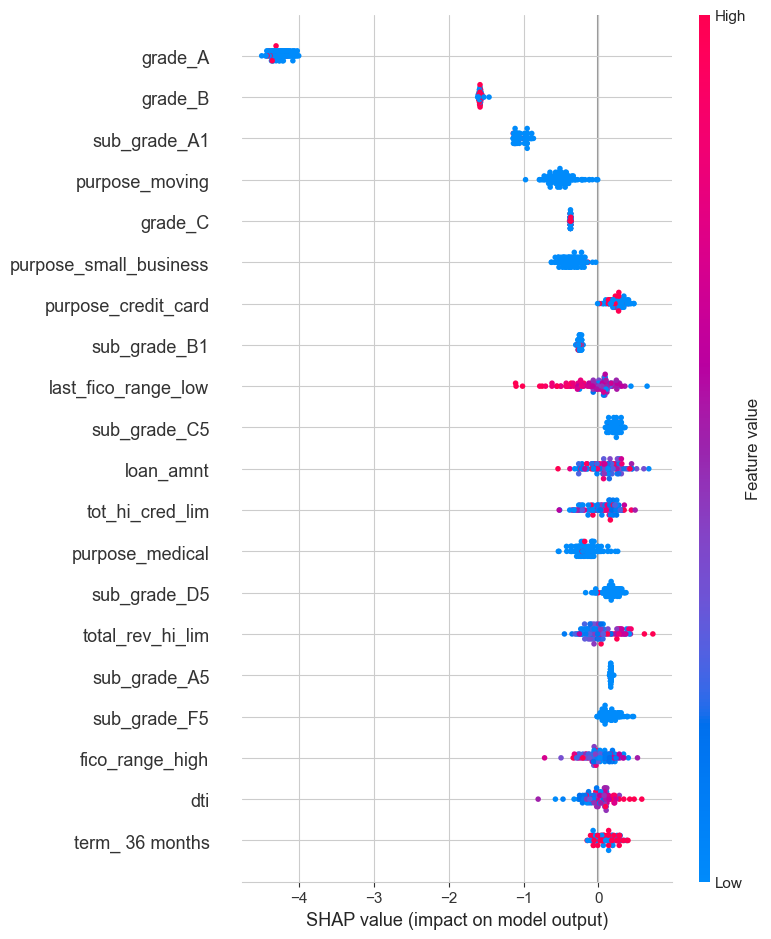

In [6]:
preprocessed_data = xgbr_int_rate_best.named_steps['preprocessor'].transform(X_test_int)

# Get feature names from model preprocessor
encoder = xgbr_int_rate_best.named_steps['preprocessor'].named_transformers_['categorical']
transformed_feature_names = encoder.named_steps['encoder'].get_feature_names_out(categorical_features_int)
all_feature_names = numeric_features_int + list(transformed_feature_names)

# Convert to DataFrame
preprocessed_data_df = pd.DataFrame(preprocessed_data.toarray(), 
                                    columns=all_feature_names)

# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgbr_int_rate_best.named_steps['regressor'])

# Calculate SHAP values for a sample of the transformed data
shap_values = explainer.shap_values(preprocessed_data_df.iloc[:100, :])

# Plot the SHAP summary plot with the correct feature names
shap.summary_plot(shap_values, preprocessed_data_df.iloc[:100, :])


# 7. Model Deployment

In [22]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "json key file"
IMAGE_NAME = "lendingclub"
PROJECT_ID = "lendingclubproject" 

Activated service account credentials for: [service-acc-ow@lendingclubproject.iam.gserviceaccount.com]


Commands used to deploy our models in docker container to google cloud:

gcloud auth configure-docker
docker build -t lendingclub.
docker tag lendingclub gcr.io/lendingclubproject/lendingclub
docker push lendingclub gcr.io/lendingclubproject/lendingclub
gcloud run deploy lendingclubpred --image=gcr.io/lendingclubproject/lendingclub --platform managed

In [50]:
# Testing loan status prediction
data = {
    'loan_amnt': [3600.0],
    'title': ['debt consolidation'],
    'risk_score': [677.0],
    'debt_to_income': [5.910],
    'emp_length': ['10+ years'],
    'year_issue': [2015]
}

url = "https://lendingclubpred-dksayomowq-uc.a.run.app/predict/loan_status"

response = requests.post(url, json=data)
response.json()

{'loan_status': [1],
 'loan_status_probability': [0.0015470096418478407, 0.9984529903581522],
 'processing_time': 0.037938}

In [51]:
# Testing grade prediction
data = {
    'fico_range_high': [679.0],
    'last_fico_range_low': [560.0],
    'term': ['36 months'],
    'percent_bc_gt_75': [0.0],
    'loan_amnt': [3600.0],
    'total_rev_hi_lim': [9300.0],
    'inq_last_6mths': [1.0],
    'acc_open_past_24mths': [4.0],
    'dti': [5.910],
    'purpose': ['debt_consolidation'],
    'tot_hi_cred_lim': [178050.0]
}

url = "https://lendingclubpred-dksayomowq-uc.a.run.app/predict/grade"

response = requests.post(url, json=data)
response.json()

{'grade': ['C'],
 'grade_probability': {'A': 0.007318053860217333,
  'B': 0.26907601952552795,
  'C': 0.4114127457141876,
  'D': 0.22259624302387238,
  'E': 0.06984701752662659,
  'F': 0.01821027509868145,
  'G': 0.0015395942609757185},
 'processing_time': 0.044833}

In [53]:
# Testing sub_grade prediction
data = {
    'fico_range_high': [679.0],
    'last_fico_range_low': [560.0],
    'term': ['36 months'],
    'percent_bc_gt_75': [0.0],
    'loan_amnt': [3600.0],
    'total_rev_hi_lim': [9300.0],
    'inq_last_6mths': [1.0],
    'acc_open_past_24mths': [4.0],
    'dti': [5.910],
    'purpose': ['debt_consolidation'],
    'tot_hi_cred_lim': [178050.0],
    'grade': ['C']
}

url = "https://lendingclubpred-dksayomowq-uc.a.run.app/predict/subg"

response = requests.post(url, json=data)
response.json()

{'processing_time': 0.028157,
 'sub_grade': ['C2'],
 'subg_probability': {'C1': 0.23822286536897916,
  'C2': 0.23888436098397822,
  'C3': 0.19028756741257608,
  'C4': 0.18996102146306978,
  'C5': 0.14264418477139673}}

In [57]:
# Testing int_rate prediction
data = {
    'fico_range_high': [679.0],
    'last_fico_range_low': [560.0],
    'term': ['36 months'],
    'percent_bc_gt_75': [0.0],
    'loan_amnt': [3600.0],
    'total_rev_hi_lim': [9300.0],
    'inq_last_6mths': [1.0],
    'acc_open_past_24mths': [4.0],
    'dti': [5.910],
    'purpose': ['debt_consolidation'],
    'tot_hi_cred_lim': [178050.0],
    'grade': ['C'],
    'sub_grade': ['C2']
}

url = "https://lendingclubpred-dksayomowq-uc.a.run.app/predict/int_rate"

response = requests.post(url, json=data)
response.json()

{'int_rate': [13.440094947814941], 'processing_time': 0.025316}

In [56]:
# Testing full prediction
data = {
    'fico_range_high': [679.0],
    'last_fico_range_low': [560.0],
    'term': ['36 months'],
    'percent_bc_gt_75': [0.0],
    'loan_amnt': [3600.0],
    'total_rev_hi_lim': [9300.0],
    'inq_last_6mths': [1.0],
    'acc_open_past_24mths': [4.0],
    'dti': [5.910],
    'purpose': ['debt_consolidation'],
    'tot_hi_cred_lim': [178050.0]
}

url = "https://lendingclubpred-dksayomowq-uc.a.run.app/predict/all"

response = requests.post(url, json=data)
response.json()

{'grade': 'C',
 'grade_probability': {'A': 0.007318053860217333,
  'B': 0.26907601952552795,
  'C': 0.4114127457141876,
  'D': 0.22259624302387238,
  'E': 0.06984701752662659,
  'F': 0.01821027509868145,
  'G': 0.0015395942609757185},
 'int_rate': 13.440094947814941,
 'processing_time': 0.051437,
 'sub_grade': ['C2'],
 'subg_probability': {'C1': 0.23822286536897916,
  'C2': 0.23888436098397822,
  'C3': 0.19028756741257608,
  'C4': 0.18996102146306978,
  'C5': 0.14264418477139673}}

# Summary

### Loan Status Model
- **Accuracy**: Achieved a remarkable 98% accuracy.
- **F1 Scores**: High F1 scores of 99% and 95% show the model's effective in 
  predicting both classes.
- **False Positives (FP)**: More FP than FN suggests adjusting the threshold to 
  minimize financial loss. Collaboration with the business team may be needed for 
  optimal adjustment.

### Loan Grade Model
- **Early Stopping**: Prevented overfitting by early stop training at 246 
estimators.
- **Accuracy**: Only 47% - low and problematic for an imbalanced dataset.
- **Performance**: Varied F1 scores across grades, with low performers indicating 
  the need for more data for minority classes.

### Loan Sub-Grade Models
- **A & B Models**: Best at predicting the extremes (1st and 5th subgrades), but 
  poor at others. Accuracy ranged from 0.29 to 0.37.
- **C to G Models**: Mainly predicted the first subgrade, with accuracies from 
  0.27 to 0.47.
- **Challenges**: Models are limited in predicting subgrades, requiring more data 
  and possibly feature engineering.

### Loan Interest Rate Model
- **Improvement**: After tuning, the MAE and MSE decreased, while R-squared 
  increased slightly.
- **Errors**: The small gap between MAE and MSE hints at some large prediction 
  errors.
- **Efficiency**: Given the range of interest rates, an MAE of 0.624 is impressive,
  suggesting a highly efficient model.

### Further Improvements:
- Collect more data of minority classes.
- Experiment more with creating new features to capture more patterns 
related to grades and subgrades.
- Use grid search to improve our models.
- Redo data preprocessing to keep more data that can be important.
- Threshold optimization for optimal FP FN scores
- Experiment with more sampling strategies.